# DTSC 691 
# Machine Learning
# Forecast Chicago Public High School College Enrollment Rate
# Haibo Li

# Goal of the project

One of the major public high schools’ goals is to get students ready for college. In 2019, 73.9% of high school students were enrolled in either four-year or two-year colleges. In Chicago, the percentage is only 63%, lower than national rate. In this study, we will use school progress reports and school profile data published by Chicago Data Portal to study college enrollment rate for Chicago public high schools. By using above datasets, a model will be built to forecast college enrollment rate for a high school based on school features. 

## Import packages

In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [2]:
IMAGES_PATH = "C:\\Users\\helenli\\691\\Project\\fig\\"
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Data Description

The datasets are all about Chicago public schools. Each row represents one school in the specific school year. 

There are two types of datasets for this project. School progress report and school profile information. The available years for the datasets are SY16/17, SY17/18, SY18/19, SY21/22, SY22/23. There is no information on School Year 19/20. School Year 20/21 does not have school progress report, so it is excluded from the project. Two types of datasets will be merged on school ID. The datasets also contain elementary and middle schools. Those would be excluded too. 

For each school year dataset, there is data about over 600 public schools, among which 180 rows are about high schools. 

School progress reports has 153 columns and school profile has 91 columns. Columns contains basic information like address and contact information will be dropped. And columns which are irrelative to high schools will be deleted. 

School progress reports will supply features such as suspension rate, misconduct rate, attendance rate, etc. School profile provides students demography, low-income rate, school performance grading etc. And college enrollment rate from School Profile is the response data. 

# Analysis Description

To build a machine learning model to forecast college enrollment rate, there are several steps to complete this project. 

Step 1, data preparation and cleaning. Since there are multiple datasets of each year and two types of datasets, datasets will be concatenated and merged. Columns and rows relating with elementary schools and middle schools will be dropped.The dataset has a large amount of missing data, with both numerical and categorical data. I will drop the columns with large percentage of missing data. 

Step 2, Exploratory data analysis will be conducted to understand the data through visualization and statistical tools. Plot histogram of each numerical feature to analyze distribution. Correlation matrix will be conducted identity collinearity. Use scatter plot to identify outliers and correlation between each numerical feature and response data.  

Step 3, Model Training: Use Factorize to label categorical features. Use logarithm to process the numerical data. Use imputer to generate missing values. Use train_test_split to split training and testing data. Will use linear regression, lasso regression, decision tree, random forest regressor, gradient boosting to build learning models. Use grid search to tune hyperparameters and cross validation to identify the best model. 

# Data Cleaning

## Merge and concatenate datasets


In [3]:
# creat empty datasets by using SY1617 data
school_profile = 'Chicago_Public_Schools_-_School_Profile_Information'
progress_reports = 'Chicago_Public_Schools_-_School_Progress_Reports'
years = ['_SY1617','_SY1718','_SY1819','_SY2122','_SY2223']
file_dir = 'C:/Users/helenli/691/Project/'
filetype='.csv'
school_profile = pd.read_csv(os.path.join(file_dir,school_profile+'_SY1617'+filetype), converters={'School_ID':str}, thousands=',')
progress_reports= pd.read_csv(os.path.join(file_dir,progress_reports+'_SY1617'+filetype), converters={'School_ID':str}, thousands=',')
HS_profile = school_profile[school_profile['Primary_Category']=='HS']
HS_progress = progress_reports[progress_reports['Primary_Category']=='HS']
HS_merged = HS_profile.merge(HS_progress, how = 'inner', on='School_ID')
empty_dataset = pd.DataFrame(columns=HS_merged.columns)
row_count = 0

In [4]:
# Merge and concatanate all datasets 
for year in years:
    profile_temp = pd.read_csv(os.path.join(file_dir,'Chicago_Public_Schools_-_School_Profile_Information' + year + filetype), converters={'School_ID':str}, thousands=',')
    progress_temp = pd.read_csv(os.path.join(file_dir,'Chicago_Public_Schools_-_School_Progress_Reports' + year + filetype), converters={'School_ID':str}, thousands=',')
    HS_profile_temp = profile_temp[profile_temp['Primary_Category']=='HS']
    HS_progress_temp = progress_temp[progress_temp['Primary_Category']=='HS']
    HS_merged_temp = profile_temp.merge(HS_progress_temp, how = 'inner', on='School_ID')
    new_row = HS_merged_temp.shape[0]
    row_count +=new_row
    HS_all = pd.concat([empty_dataset,HS_merged_temp], axis=0, join='inner')
    empty_dataset = HS_all
if row_count == empty_dataset.shape[0]:  
    all_school=empty_dataset              

In [5]:
all_school.shape

(879, 230)

In [6]:
#Drop irrelavent columns
all_school_reduced= all_school.loc[:,['Student_Count_Total','Student_Count_Low_Income','Student_Count_Special_Ed',
                                                        'Student_Count_English_Learners','Student_Count_Black','Student_Count_Hispanic','Student_Count_White',
                                                        'Student_Count_Asian','Student_Count_Native_American','Student_Count_Other_Ethnicity','Student_Count_Asian_Pacific_Islander',
                                                        'Student_Count_Multi', 'Student_Count_Hawaiian_Pacific_Islander','Student_Count_Ethnicity_Not_Available','Bilingual_Services',
                                                        'Refugee_Services','Title_1_Eligible','Average_ACT_School','College_Enrollment_Rate_School','Graduation_Rate_School','Overall_Rating',
                                                        'Student_Growth_Rating','Student_Attainment_Rating','Culture_Climate_Rating','School_Survey_Student_Response_Rate_Pct','School_Survey_Teacher_Response_Rate_Pct',
                                                        'Creative_School_Certification','School_Survey_Involved_Families','School_Survey_Supportive_Environment','School_Survey_Ambitious_Instruction',
                                                        'School_Survey_Effective_Leaders','School_Survey_Collaborative_Teachers','School_Survey_Safety','Suspensions_Per_100_Students_Year_1_Pct','Suspensions_Per_100_Students_Year_2_Pct',
                                                        'Misconducts_To_Suspensions_Year_1_Pct','Misconducts_To_Suspensions_Year_2_Pct','Average_Length_Suspension_Year_1_Pct','Average_Length_Suspension_Year_2_Pct','Student_Attendance_Year_1_Pct',
                                                        'Student_Attendance_Year_2_Pct','Teacher_Attendance_Year_1_Pct','Teacher_Attendance_Year_2_Pct','One_Year_Dropout_Rate_Year_1_Pct','One_Year_Dropout_Rate_Year_2_Pct',
                                                        'Freshmen_On_Track_School_Pct_Year_2','Freshmen_On_Track_School_Pct_Year_1','Graduation_4_Year_School_Pct_Year_2','Graduation_4_Year_School_Pct_Year_1',
                                                        'Graduation_5_Year_School_Pct_Year_2','Graduation_5_Year_School_Pct_Year_1','Mobility_Rate_Pct']]

In [7]:
all_school_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 879 entries, 0 to 170
Data columns (total 52 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Student_Count_Total                      879 non-null    object 
 1   Student_Count_Low_Income                 879 non-null    object 
 2   Student_Count_Special_Ed                 879 non-null    object 
 3   Student_Count_English_Learners           879 non-null    object 
 4   Student_Count_Black                      879 non-null    object 
 5   Student_Count_Hispanic                   879 non-null    object 
 6   Student_Count_White                      879 non-null    object 
 7   Student_Count_Asian                      879 non-null    object 
 8   Student_Count_Native_American            879 non-null    object 
 9   Student_Count_Other_Ethnicity            879 non-null    object 
 10  Student_Count_Asian_Pacific_Islander     879 non-n

In [8]:
# Generate demographic percentage data
# Change object data to float
all_school_reduced['Student_Count_Total'] = all_school_reduced['Student_Count_Total'].astype(float)
all_school_reduced['Student_Count_Low_Income'] = all_school_reduced['Student_Count_Low_Income'].astype(float)
all_school_reduced['Student_Count_Special_Ed'] = all_school_reduced['Student_Count_Special_Ed'].astype(float)
all_school_reduced['Student_Count_English_Learners'] = all_school_reduced['Student_Count_English_Learners'].astype(float)
all_school_reduced['Student_Count_Black'] = all_school_reduced['Student_Count_Black'].astype(float)
all_school_reduced['Student_Count_Hispanic'] = all_school_reduced['Student_Count_Hispanic'].astype(float)
all_school_reduced['Student_Count_White'] = all_school_reduced['Student_Count_White'].astype(float)
all_school_reduced['Student_Count_Asian' ] = all_school_reduced['Student_Count_Asian'].astype(float)
all_school_reduced['Student_Count_Native_American'] = all_school_reduced['Student_Count_Native_American'].astype(float)
all_school_reduced['Student_Count_Other_Ethnicity'] = all_school_reduced['Student_Count_Other_Ethnicity'].astype(float)
all_school_reduced['Student_Count_Asian_Pacific_Islander'] = all_school_reduced['Student_Count_Asian_Pacific_Islander'].astype(float)
all_school_reduced['Student_Count_Multi'] = all_school_reduced['Student_Count_Multi'].astype(float)
all_school_reduced['Student_Count_Hawaiian_Pacific_Islander'] = all_school_reduced['Student_Count_Hawaiian_Pacific_Islander'].astype(float)
all_school_reduced['Student_Count_Ethnicity_Not_Available'] = all_school_reduced['Student_Count_Ethnicity_Not_Available'].astype(float)

all_school_reduced['Student_Low_Income_Pct']=round(all_school_reduced['Student_Count_Low_Income']/all_school_reduced['Student_Count_Total']*100,2)
all_school_reduced['Student_Special_Ed_Pct']=round(all_school_reduced['Student_Count_Special_Ed']/all_school_reduced['Student_Count_Total']*100,2)
all_school_reduced['Student_English_Learners_Pct']=round(all_school_reduced['Student_Count_English_Learners']/all_school_reduced['Student_Count_Total']*100,2)
all_school_reduced['Student_Black_Pct']=round(all_school_reduced['Student_Count_Black']/all_school_reduced['Student_Count_Total']*100,2)
all_school_reduced['Student_Hispanic_Pct']=round(all_school_reduced['Student_Count_Hispanic']/all_school_reduced['Student_Count_Total']*100,2)
all_school_reduced['Student_White_Pct']=round(all_school_reduced['Student_Count_White']/all_school_reduced['Student_Count_Total']*100,2)
all_school_reduced['Student_Asian_Pct']=round(all_school_reduced['Student_Count_Asian']/all_school_reduced['Student_Count_Total']*100,2)
all_school_reduced['Student_Native_American_Pct']=round(all_school_reduced['Student_Count_Native_American']/all_school_reduced['Student_Count_Total']*100,2)
all_school_reduced['Student_Other_Ethnicity_Pct']=round(all_school_reduced['Student_Count_Other_Ethnicity']/all_school_reduced['Student_Count_Total']*100,2)
all_school_reduced['Student_Asian_Pacific_Islander_Pct']=round(all_school_reduced['Student_Count_Asian_Pacific_Islander']/all_school_reduced['Student_Count_Total']*100,2)
all_school_reduced['Student_Ethnicity_Not_Available_Pct']=round(all_school_reduced['Student_Count_Ethnicity_Not_Available']/all_school_reduced['Student_Count_Total']*100,2)
all_school_reduced['Student_Multi_Pct'] = round(all_school_reduced['Student_Count_Multi']/all_school_reduced['Student_Count_Total']*100,2)
all_school_reduced['Student_Hawaiian_Pacific_Islander_Pct'] = round(all_school_reduced['Student_Count_Hawaiian_Pacific_Islander']/all_school_reduced['Student_Count_Total']*100,2)


In [9]:
all_school_reduced.head(3)

,Student_Count_Total,Student_Count_Low_Income,Student_Count_Special_Ed,Student_Count_English_Learners,Student_Count_Black,Student_Count_Hispanic,Student_Count_White,Student_Count_Asian,Student_Count_Native_American,Student_Count_Other_Ethnicity,...,Student_Black_Pct,Student_Hispanic_Pct,Student_White_Pct,Student_Asian_Pct,Student_Native_American_Pct,Student_Other_Ethnicity_Pct,Student_Asian_Pacific_Islander_Pct,Student_Ethnicity_Not_Available_Pct,Student_Multi_Pct,Student_Hawaiian_Pacific_Islander_Pct
0,900.0,788.0,153.0,57.0,459.0,420.0,7.0,2.0,5.0,0.0,...,51.00,46.67,0.78,0.22,0.56,0.0,0.0,0.0,0.67,0.11
1,38.0,37.0,6.0,2.0,28.0,8.0,2.0,0.0,0.0,0.0,...,73.68,21.05,5.26,0.00,0.00,0.0,0.0,0.0,0.00,0.00
2,341.0,320.0,57.0,31.0,187.0,148.0,4.0,0.0,1.0,0.0,...,54.84,43.40,1.17,0.00,0.29,0.0,0.0,0.0,0.29,0.00


In [10]:
all_school_reduced.College_Enrollment_Rate_School.isna().sum()
all_school_reduced.dropna(subset=['College_Enrollment_Rate_School'], inplace=True)

In [11]:
all_school_reduced.shape

(803, 65)

In [12]:
# drop columns which was used to caculate students' demographic percentage 
all_school_reduced.drop(columns=['Student_Count_Total','Student_Count_Low_Income','Student_Count_Special_Ed','Student_Count_English_Learners','Student_Count_Black',
                                 'Student_Count_Hispanic','Student_Count_White','Student_Count_Asian','Student_Count_Native_American','Student_Count_Other_Ethnicity',
                                 'Student_Count_Asian_Pacific_Islander','Student_Count_Ethnicity_Not_Available','Student_Count_Multi','Student_Count_Hawaiian_Pacific_Islander'], inplace=True)

In [13]:
all_school_reduced.replace("NO DATA AVAILABLE",np.NaN, inplace=True)
all_school_reduced.replace("NOT ENOUGH DATA", np.NaN, inplace=True)
all_school_reduced.replace("INCOMPLETE DATA", np.NaN, inplace=True)
all_school_reduced.replace({True:'Y', False:'N'}, inplace=True)

In [14]:
categorial_col = [col for col in all_school_reduced.columns.values if all_school_reduced[col].dtype == 'object']

In [15]:
categorial_col

['Bilingual_Services',
 'Refugee_Services',
 'Title_1_Eligible',
 'Overall_Rating',
 'Student_Growth_Rating',
 'Student_Attainment_Rating',
 'Culture_Climate_Rating',
 'Creative_School_Certification',
 'School_Survey_Involved_Families',
 'School_Survey_Supportive_Environment',
 'School_Survey_Ambitious_Instruction',
 'School_Survey_Effective_Leaders',
 'School_Survey_Collaborative_Teachers',
 'School_Survey_Safety',
 'Average_Length_Suspension_Year_1_Pct',
 'Average_Length_Suspension_Year_2_Pct']

## Plot categorical data to check mistakes

In [16]:

def hist_plot(dataframe, col):
    for i in range(len(col)):
            fig=plt.figure(figsize=(20,5))
            ax1 = plt.subplot(111)
            dataframe[col[i]].hist(bins=20,ax=ax1)
            ax1.set_title(col[i])
            save_fig(col[i])
            fig.show()
 

Saving figure Bilingual_Services


C:\Users\helenli\AppData\Local\Temp\ipykernel_11056\1866695826.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Saving figure Refugee_Services
Saving figure Title_1_Eligible
Saving figure Overall_Rating
Saving figure Student_Growth_Rating
Saving figure Student_Attainment_Rating
Saving figure Culture_Climate_Rating
Saving figure Creative_School_Certification
Saving figure School_Survey_Involved_Families
Saving figure School_Survey_Supportive_Environment
Saving figure School_Survey_Ambitious_Instruction
Saving figure School_Survey_Effective_Leaders
Saving figure School_Survey_Collaborative_Teachers
Saving figure School_Survey_Safety
Saving figure Average_Length_Suspension_Year_1_Pct
Saving figure Average_Length_Suspension_Year_2_Pct


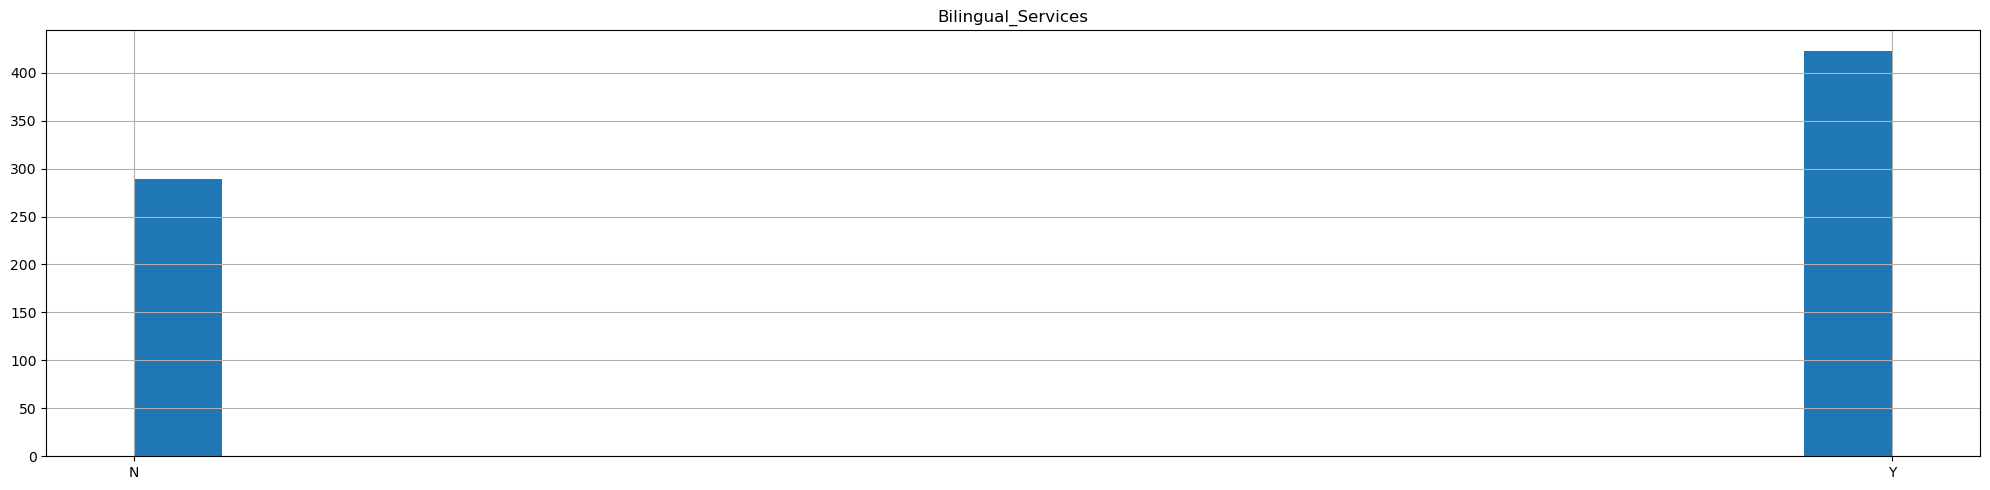

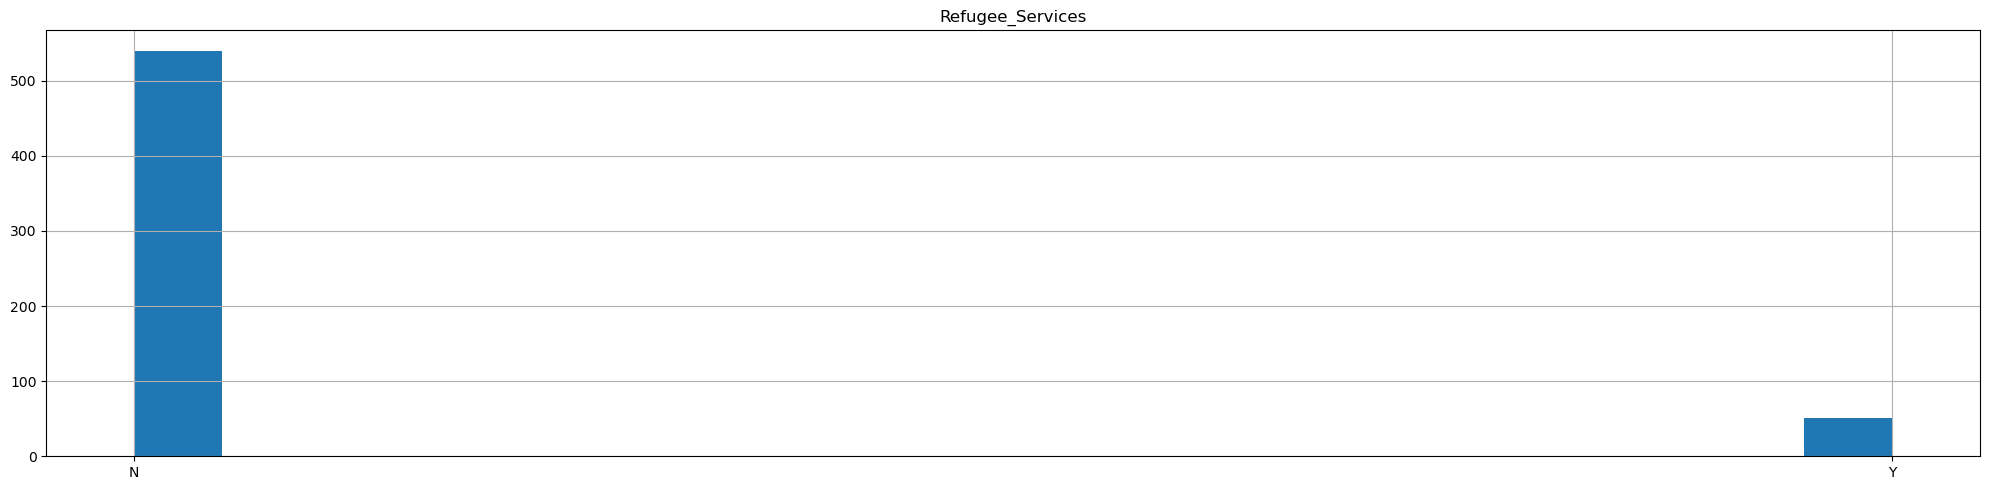

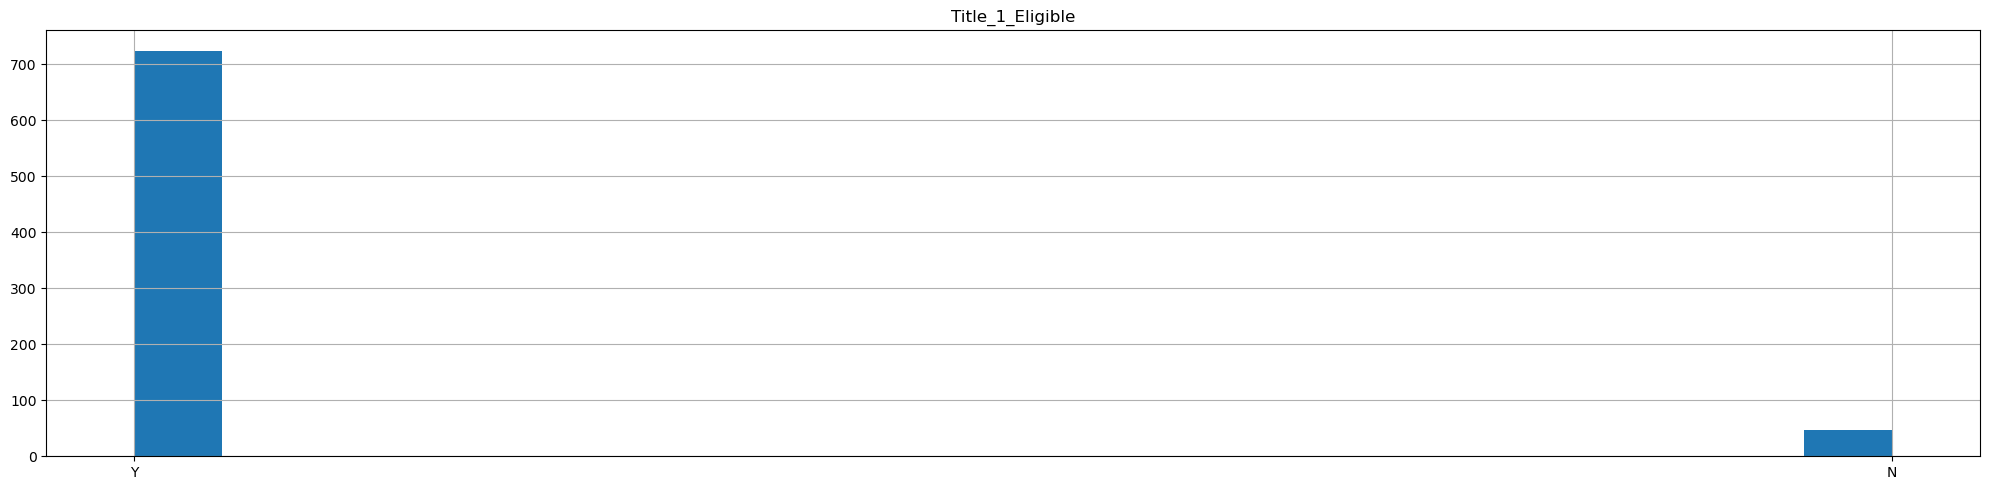

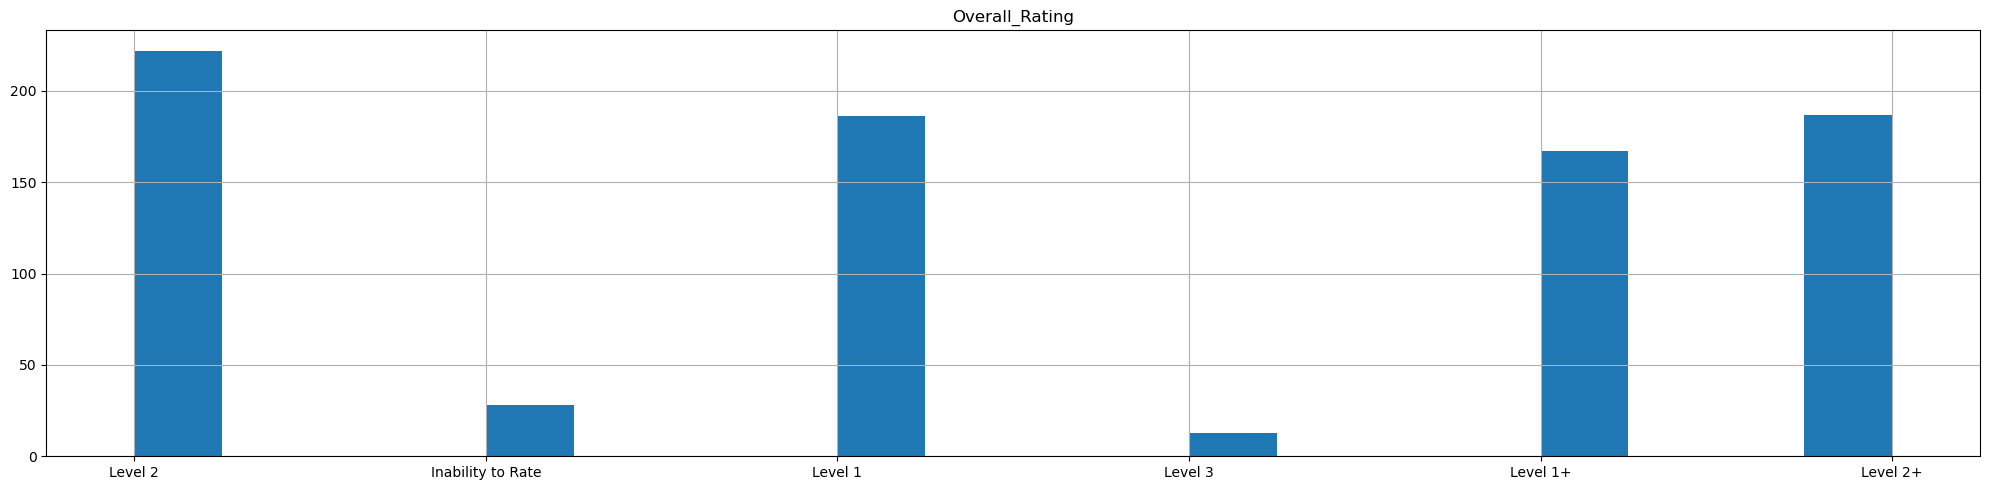

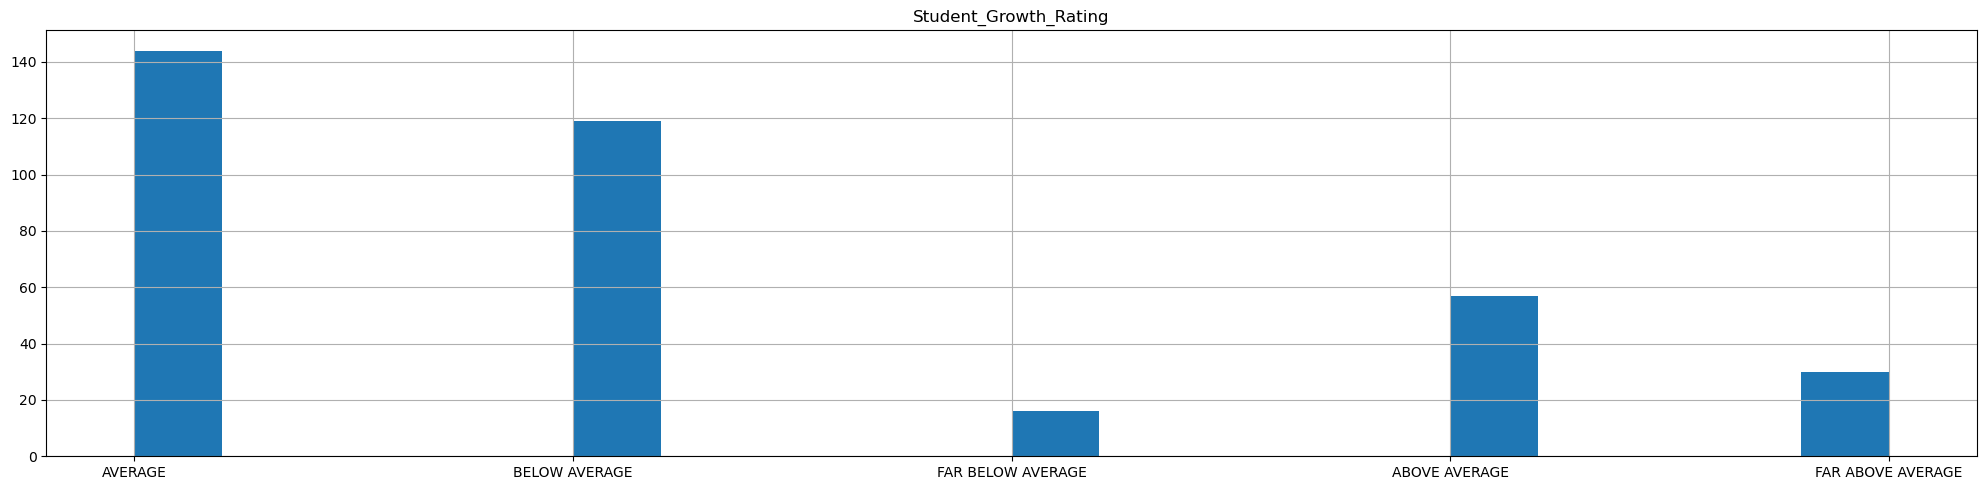

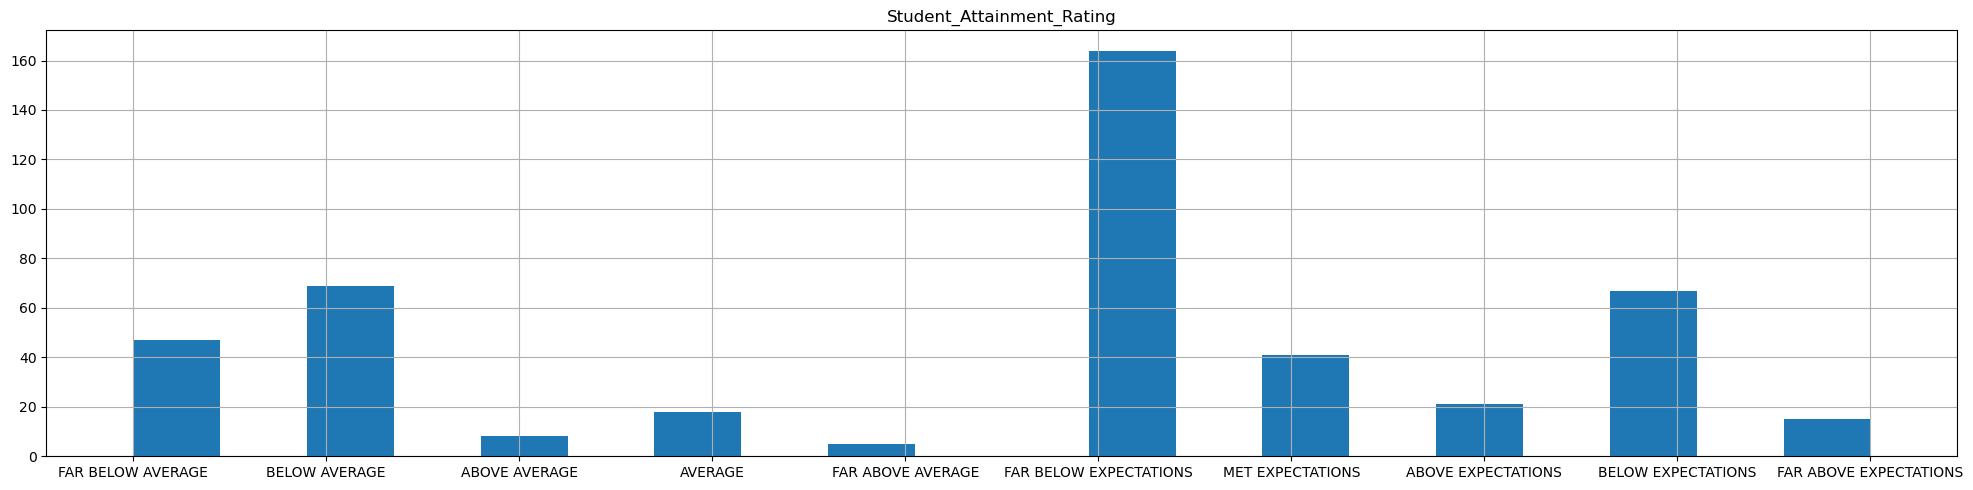

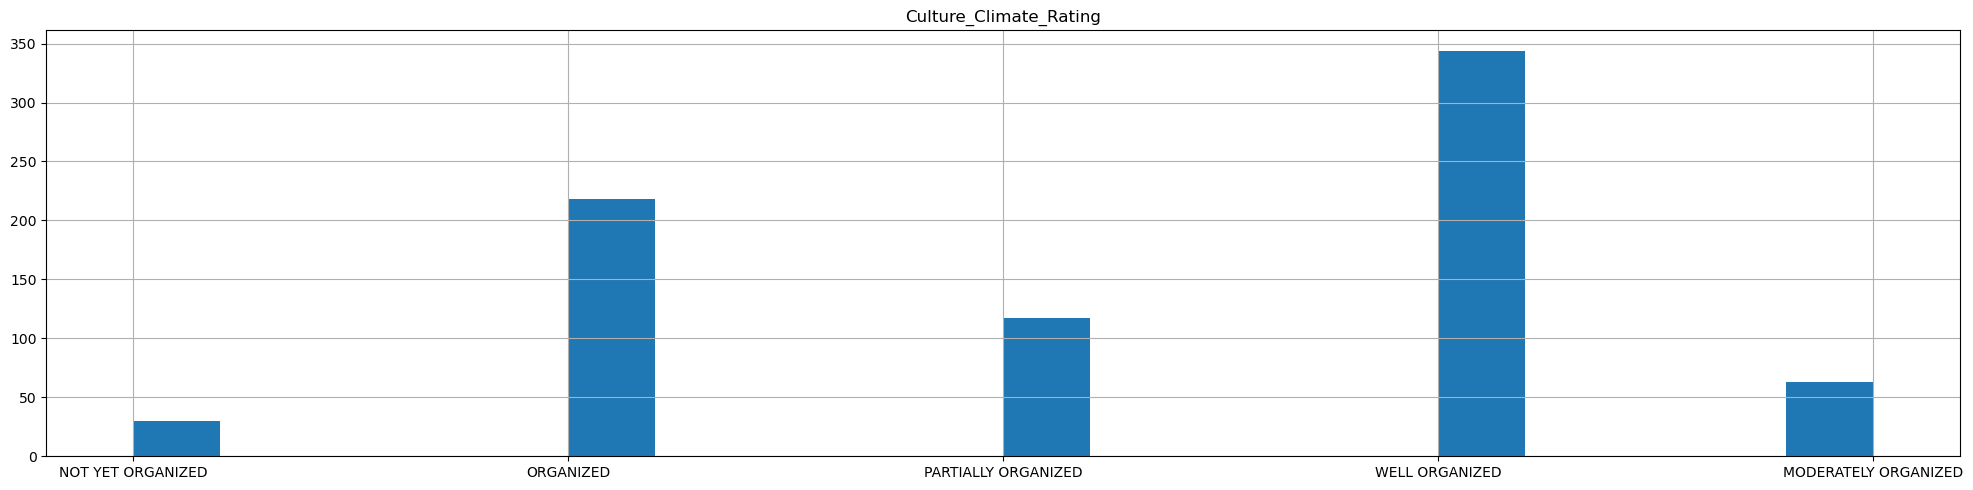

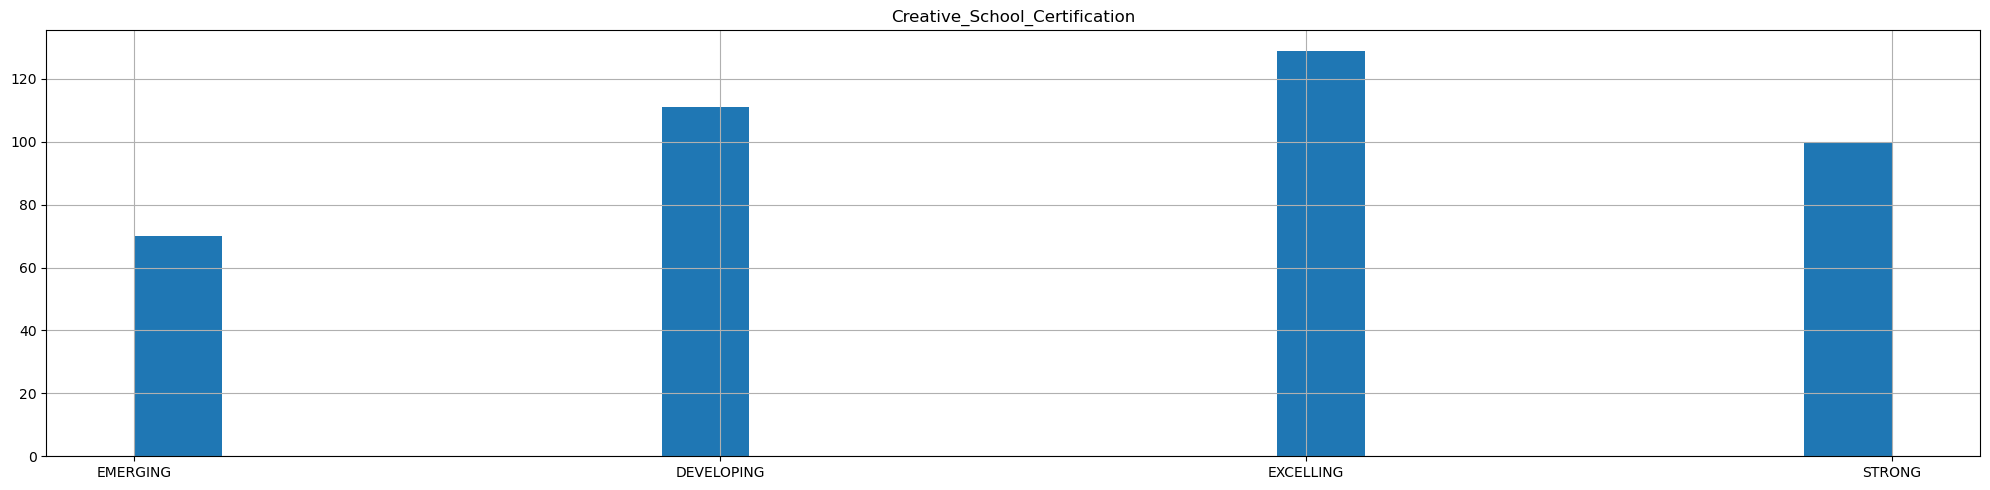

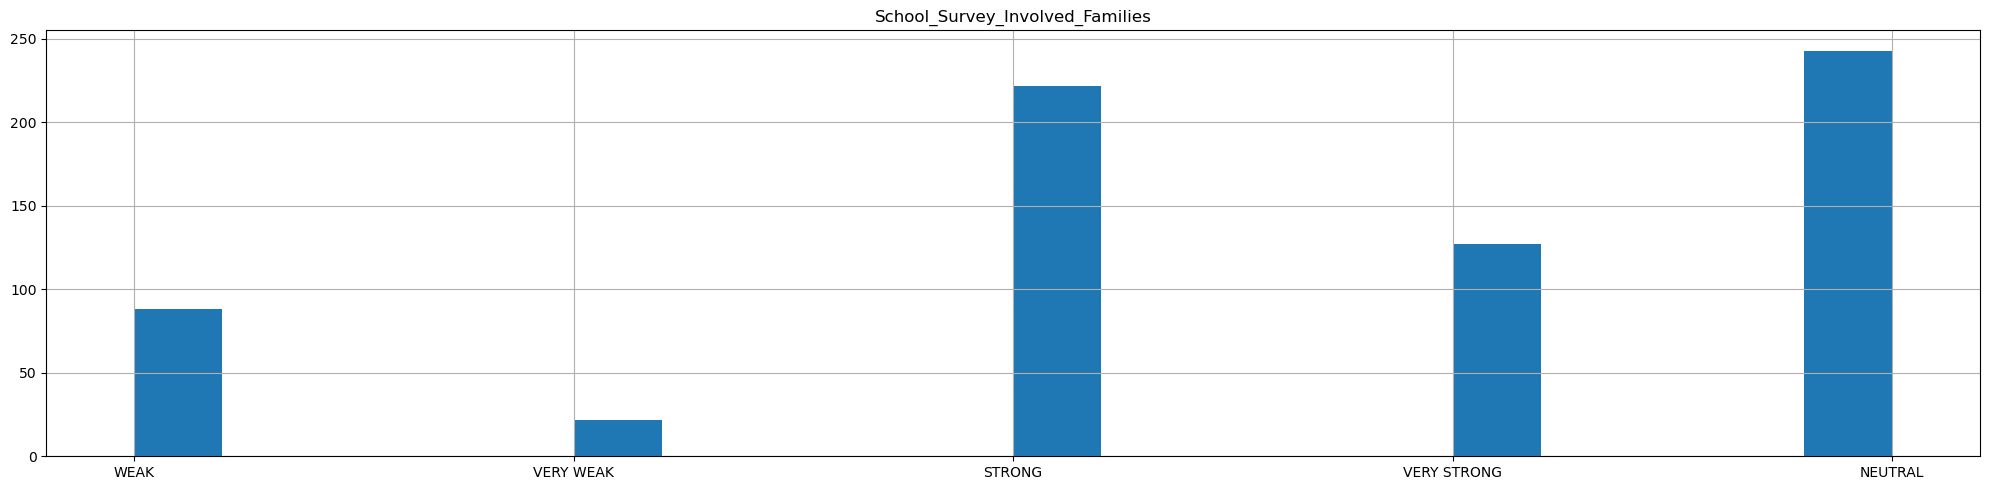

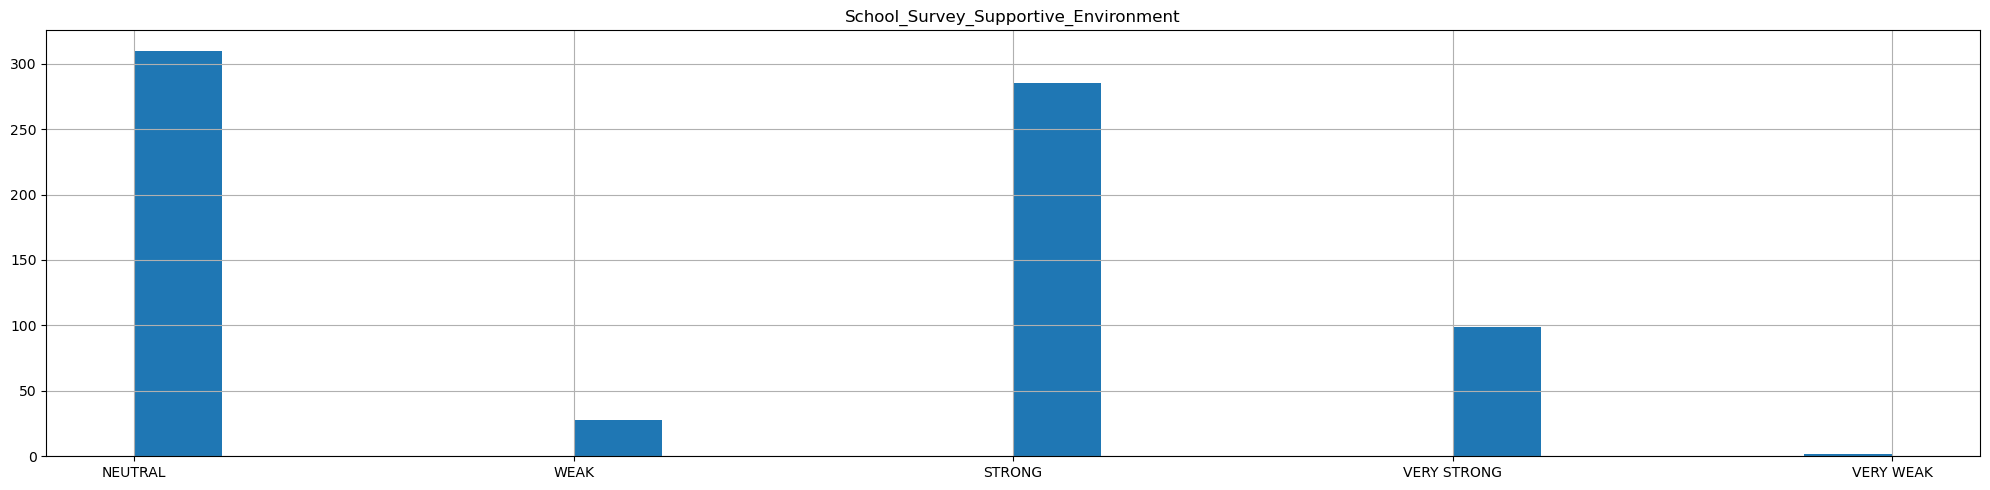

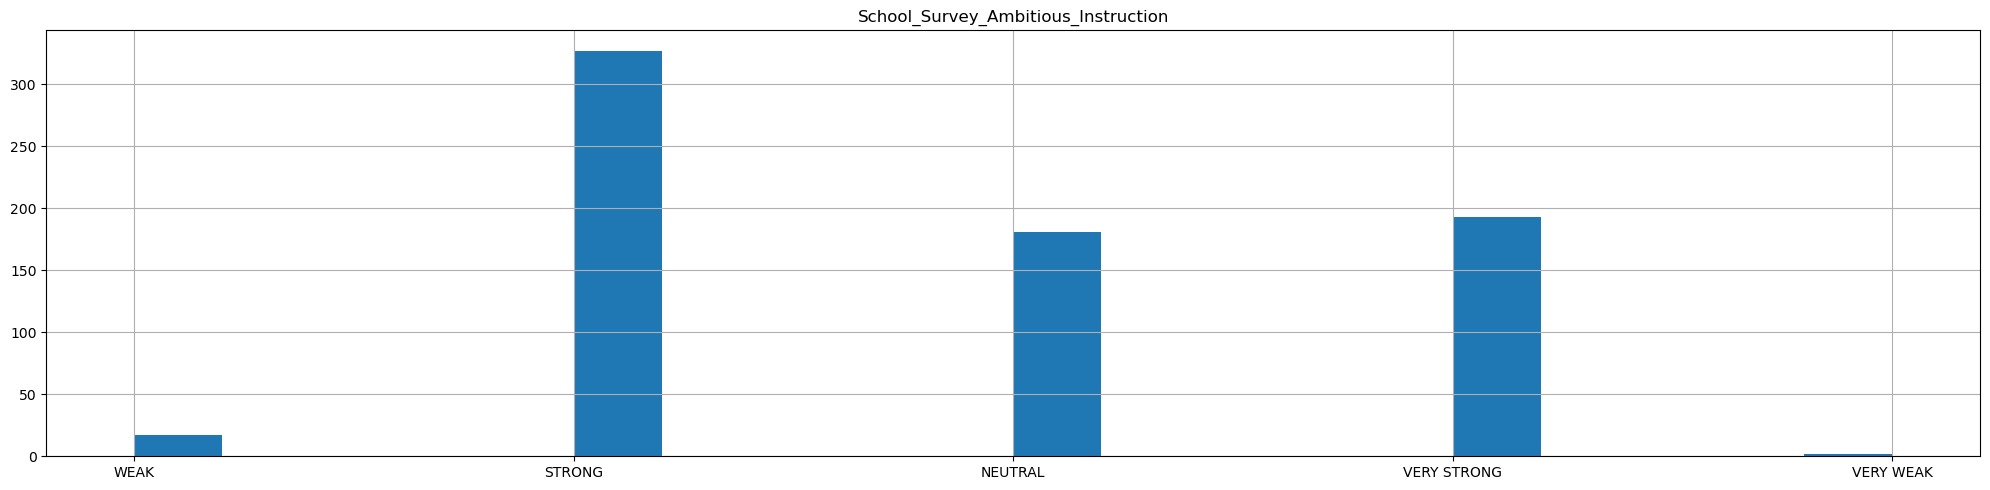

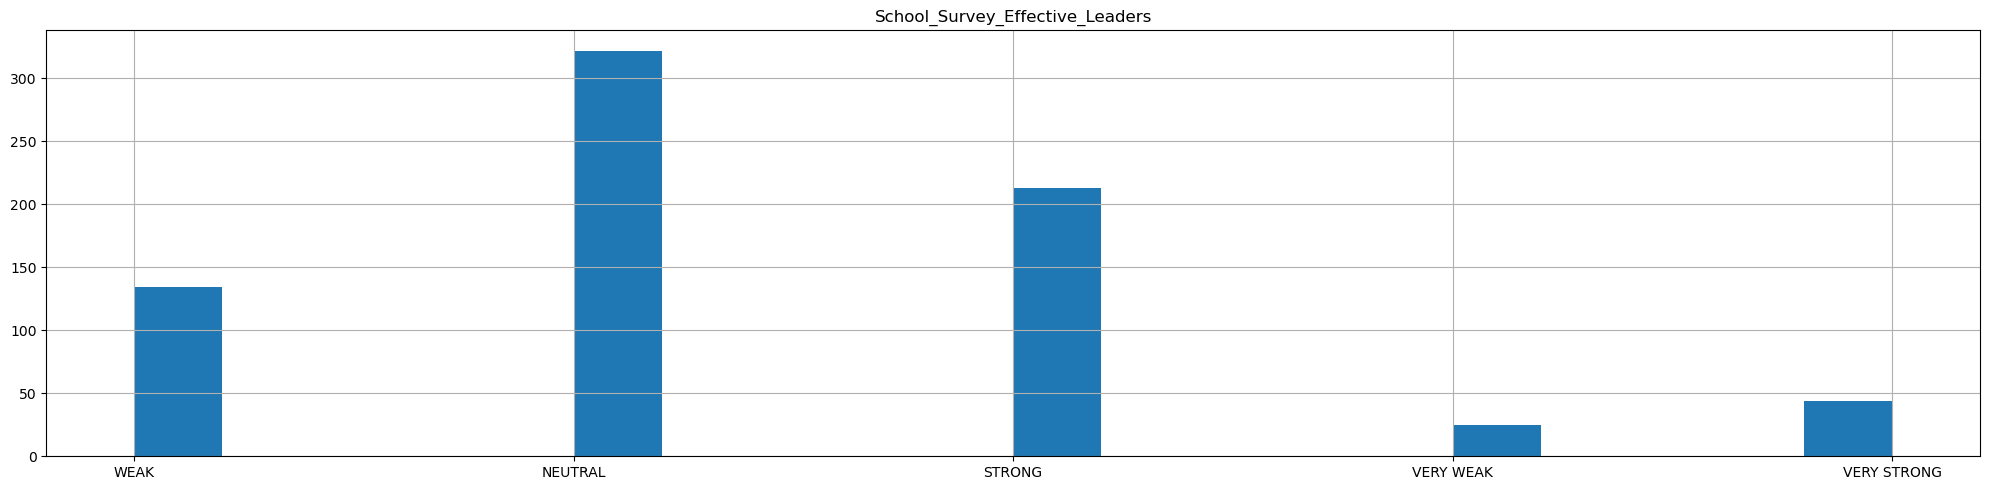

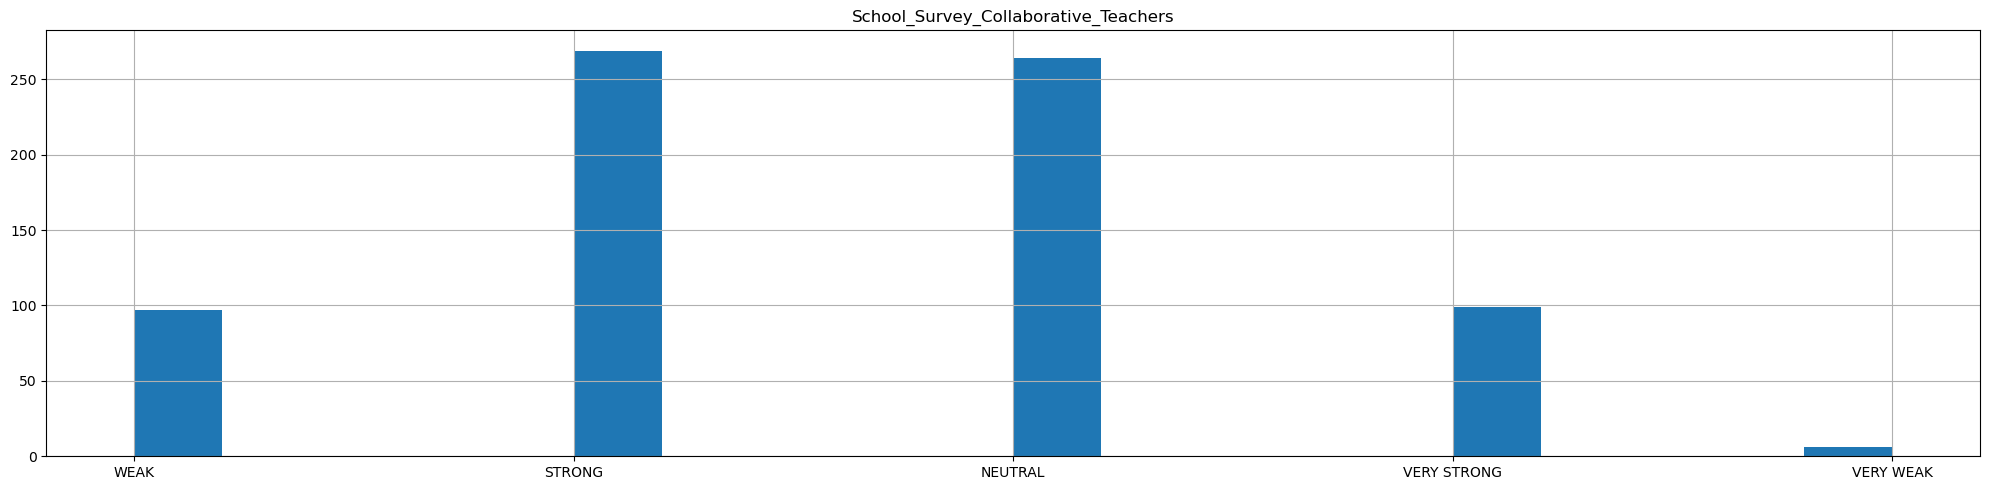

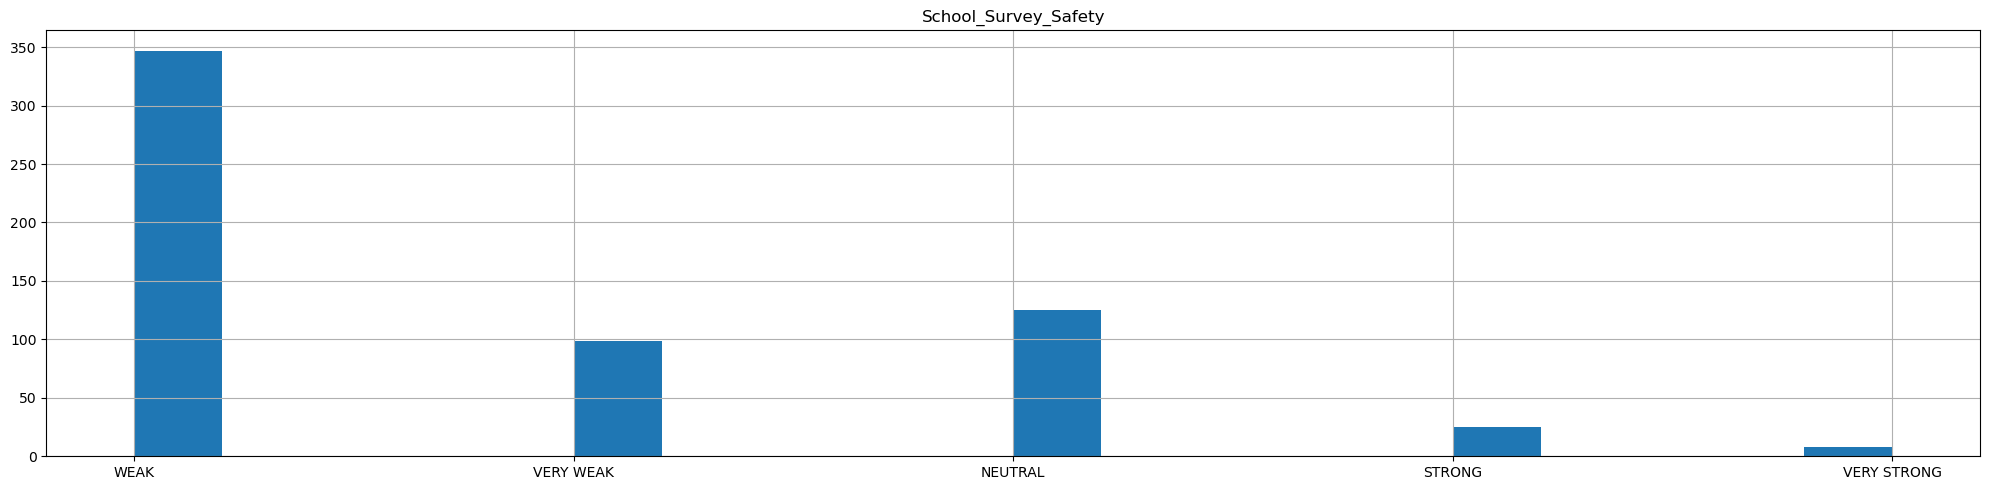

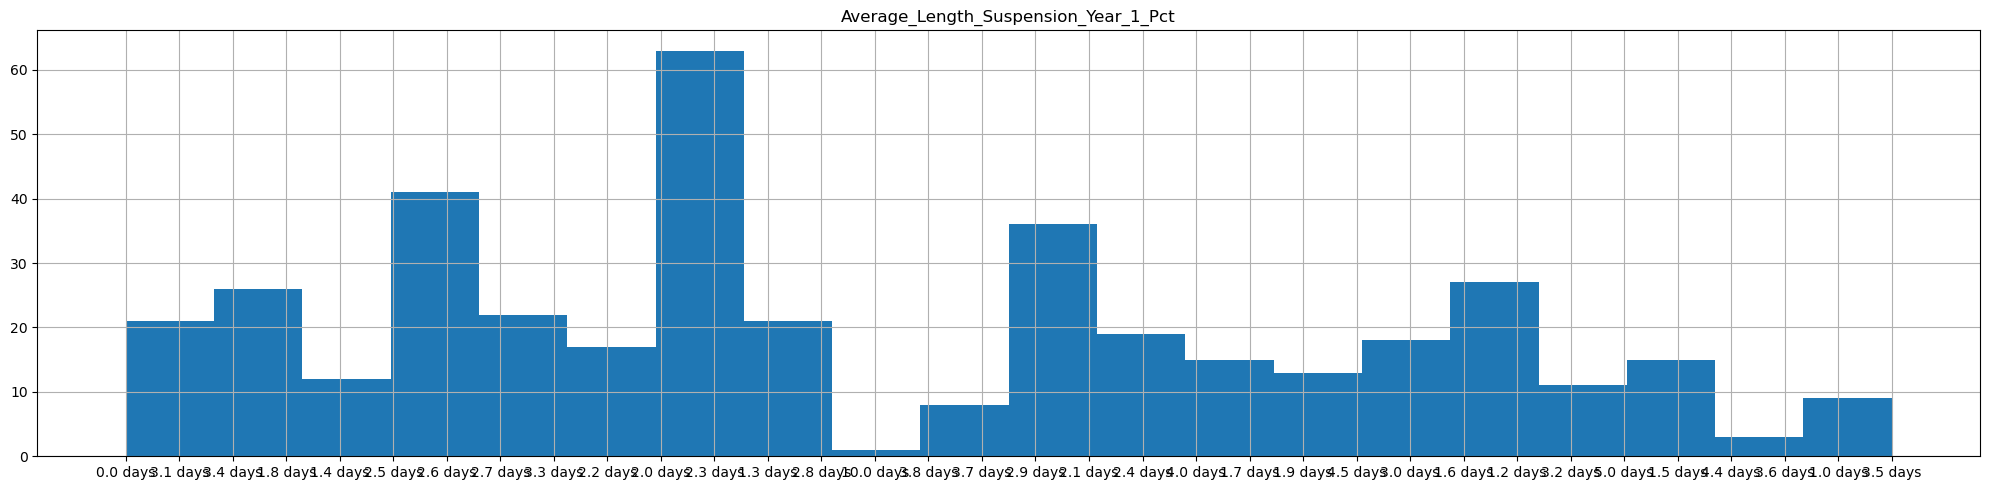

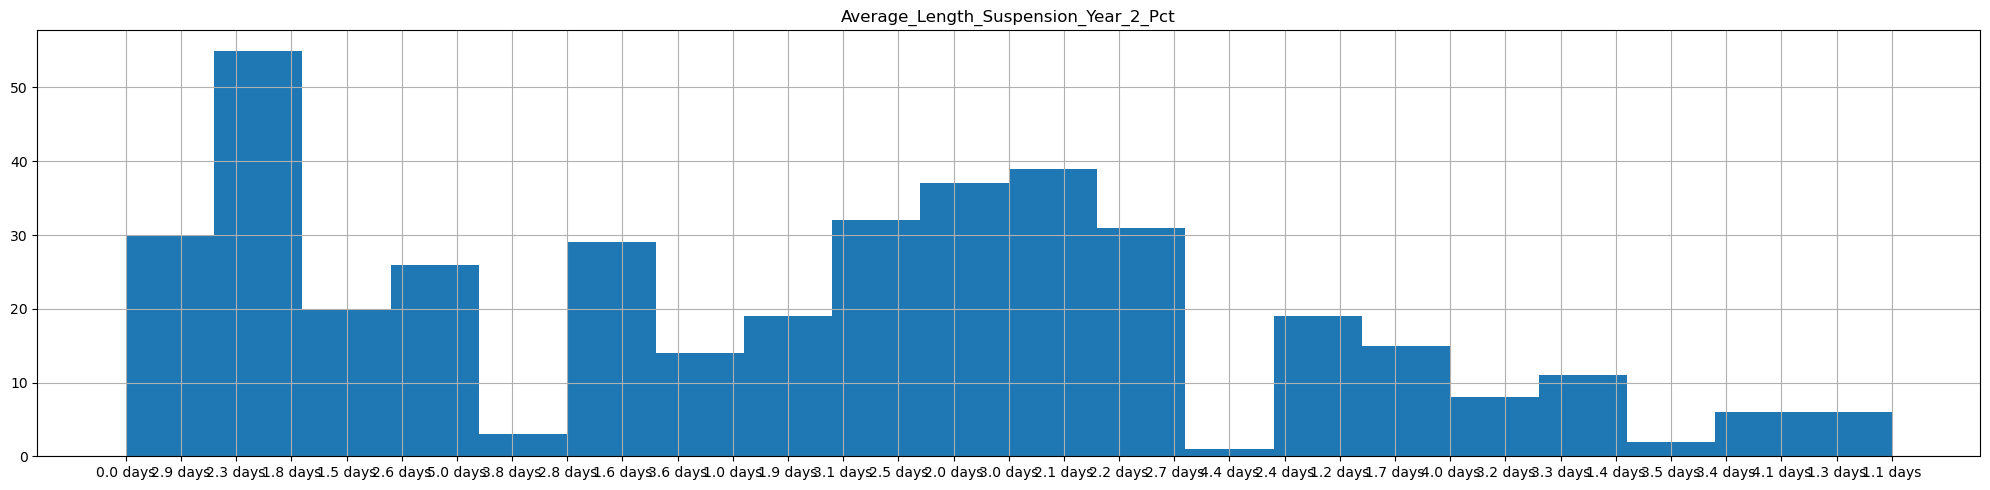

In [17]:
hist_plot(all_school_reduced, categorial_col)

In [18]:
# Process and change Average_Length_Suspension_Year_1_Pct and Average_Length_Suspension_Year_2_Pct columns to float
all_school_reduced['Average_Length_Suspension_Year_1_Pct'] = all_school_reduced['Average_Length_Suspension_Year_1_Pct'].str.split().str[0].astype("float")
all_school_reduced['Average_Length_Suspension_Year_2_Pct'] = all_school_reduced['Average_Length_Suspension_Year_2_Pct'].str.split().str[0].astype("float")

In [19]:
# Process Student_Attainment_Rating column
all_school_reduced['Student_Attainment_Rating'] = all_school_reduced['Student_Attainment_Rating'].str.replace("EXPECTATIONS", "AVERAGE")
all_school_reduced['Student_Attainment_Rating'] = all_school_reduced['Student_Attainment_Rating'].str.replace("MET AVERAGE", "AVERAGE")
all_school_reduced['Student_Attainment_Rating'].value_counts()

FAR BELOW AVERAGE    211
BELOW AVERAGE        136
AVERAGE               59
ABOVE AVERAGE         29
FAR ABOVE AVERAGE     20
Name: Student_Attainment_Rating, dtype: int64

In [20]:
all_school_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 803 entries, 2 to 170
Data columns (total 51 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Bilingual_Services                       712 non-null    object 
 1   Refugee_Services                         591 non-null    object 
 2   Title_1_Eligible                         771 non-null    object 
 3   Average_ACT_School                       152 non-null    float64
 4   College_Enrollment_Rate_School           803 non-null    float64
 5   Graduation_Rate_School                   650 non-null    float64
 6   Overall_Rating                           803 non-null    object 
 7   Student_Growth_Rating                    366 non-null    object 
 8   Student_Attainment_Rating                455 non-null    object 
 9   Culture_Climate_Rating                   772 non-null    object 
 10  School_Survey_Student_Response_Rate_Pct  799 non-n

In [21]:
categorial_col = [col for col in all_school_reduced.columns.values if all_school_reduced[col].dtype == 'object']
numerical_col = [col for col in all_school_reduced.columns.values if all_school_reduced[col].dtype == 'float64']

In [22]:
all_school_reduced.describe()

,Average_ACT_School,College_Enrollment_Rate_School,Graduation_Rate_School,School_Survey_Student_Response_Rate_Pct,School_Survey_Teacher_Response_Rate_Pct,Suspensions_Per_100_Students_Year_1_Pct,Suspensions_Per_100_Students_Year_2_Pct,Misconducts_To_Suspensions_Year_1_Pct,Misconducts_To_Suspensions_Year_2_Pct,Average_Length_Suspension_Year_1_Pct,...,Student_Black_Pct,Student_Hispanic_Pct,Student_White_Pct,Student_Asian_Pct,Student_Native_American_Pct,Student_Other_Ethnicity_Pct,Student_Asian_Pacific_Islander_Pct,Student_Ethnicity_Not_Available_Pct,Student_Multi_Pct,Student_Hawaiian_Pacific_Islander_Pct
count,152.000000,803.000000,650.000000,799.000000,800.000000,400.000000,403.000000,400.000000,403.000000,398.000000,...,797.000000,797.000000,797.000000,797.000000,797.000000,797.0,797.000000,797.000000,797.000000,797.000000
mean,16.703289,54.099377,74.082154,68.280476,78.849375,17.992750,16.896526,28.640500,28.765012,2.284422,...,52.261593,39.249235,4.822083,2.145859,0.260790,0.0,0.003827,0.386688,0.741368,0.128394
std,3.189208,25.623918,21.689901,19.545848,14.899478,26.215769,22.890549,23.244938,23.074550,0.894038,...,38.044805,34.143364,8.869392,4.719774,0.360337,0.0,0.037049,1.108272,0.946842,0.274943
min,12.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,14.500000,34.400000,68.800000,55.750000,68.800000,2.775000,2.600000,12.000000,12.050000,1.800000,...,12.850000,3.600000,0.160000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,15.700000,59.500000,79.600000,69.400000,80.450000,8.100000,8.100000,22.150000,22.600000,2.200000,...,47.120000,34.570000,0.990000,0.000000,0.150000,0.0,0.000000,0.000000,0.420000,0.000000
75%,18.100000,76.200000,87.275000,83.650000,90.000000,20.375000,21.150000,40.700000,38.350000,2.700000,...,95.320000,71.650000,4.460000,1.180000,0.380000,0.0,0.000000,0.250000,0.990000,0.160000
max,29.600000,93.700000,99.100000,99.900000,99.900000,193.400000,193.400000,100.000000,100.000000,10.000000,...,100.000000,100.000000,46.600000,30.700000,2.780000,0.0,0.650000,10.720000,5.030000,2.780000


## Plot numerical data

In [23]:
def numerical_plot(dataframe, col):
    for i in range(len(col)):
            fig=plt.figure(figsize=(20,5))
            ax1 = plt.subplot(121)
            ax2 = plt.subplot(122)
            dataframe[col[i]].hist(bins=20,ax=ax1)
            ax2.scatter(dataframe[col[i]],dataframe['College_Enrollment_Rate_School'])
            ax1.set_title(col[i])
            fig.show()

C:\Users\helenli\AppData\Local\Temp\ipykernel_11056\3369556933.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\helenli\AppData\Local\Temp\ipykernel_11056\3369556933.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig=plt.figure(figsize=(20,5))


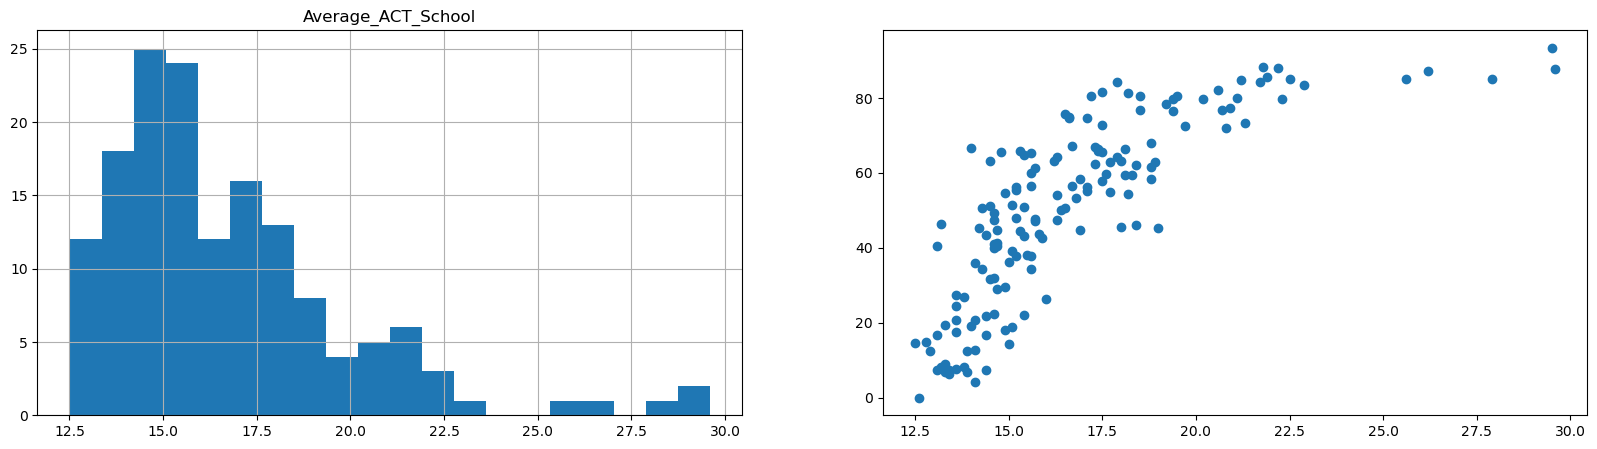

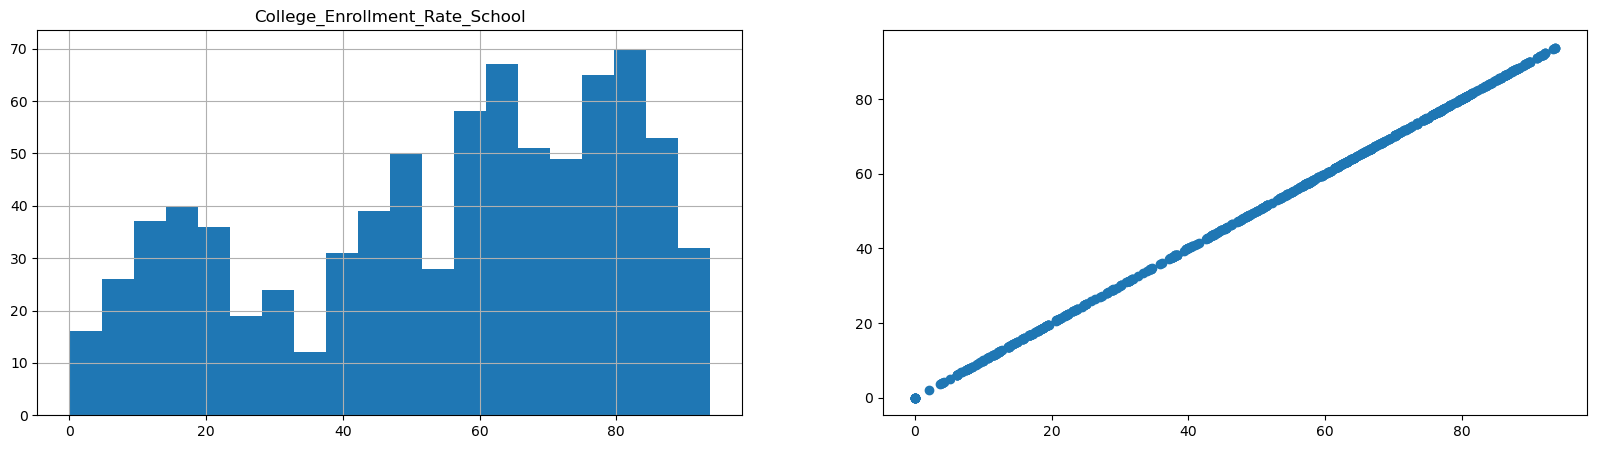

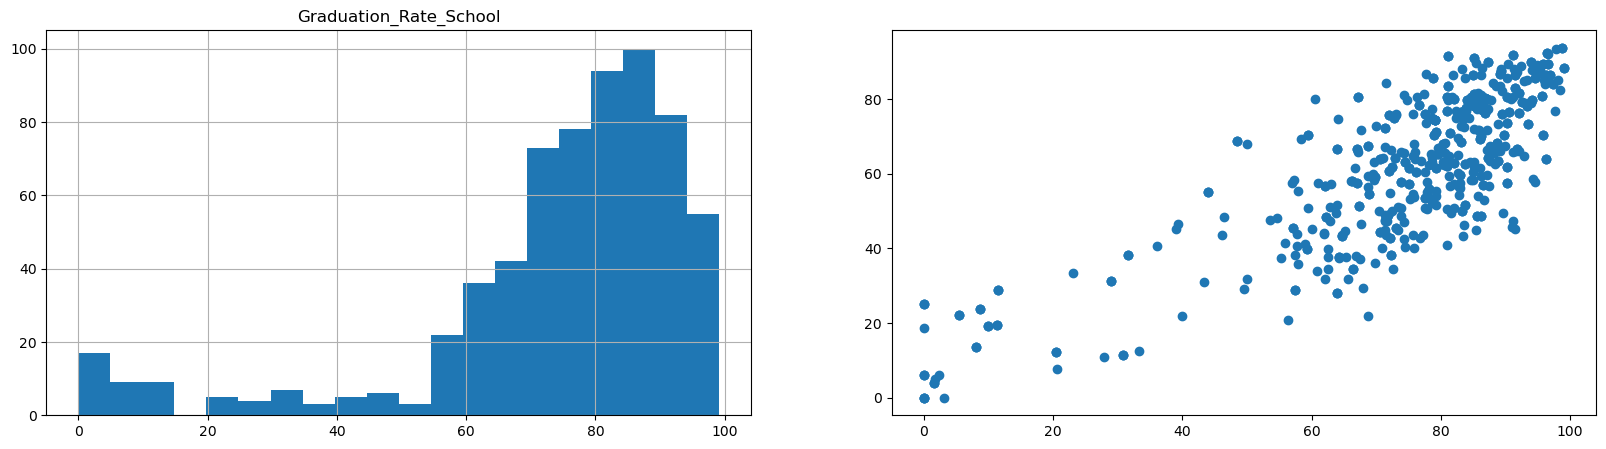

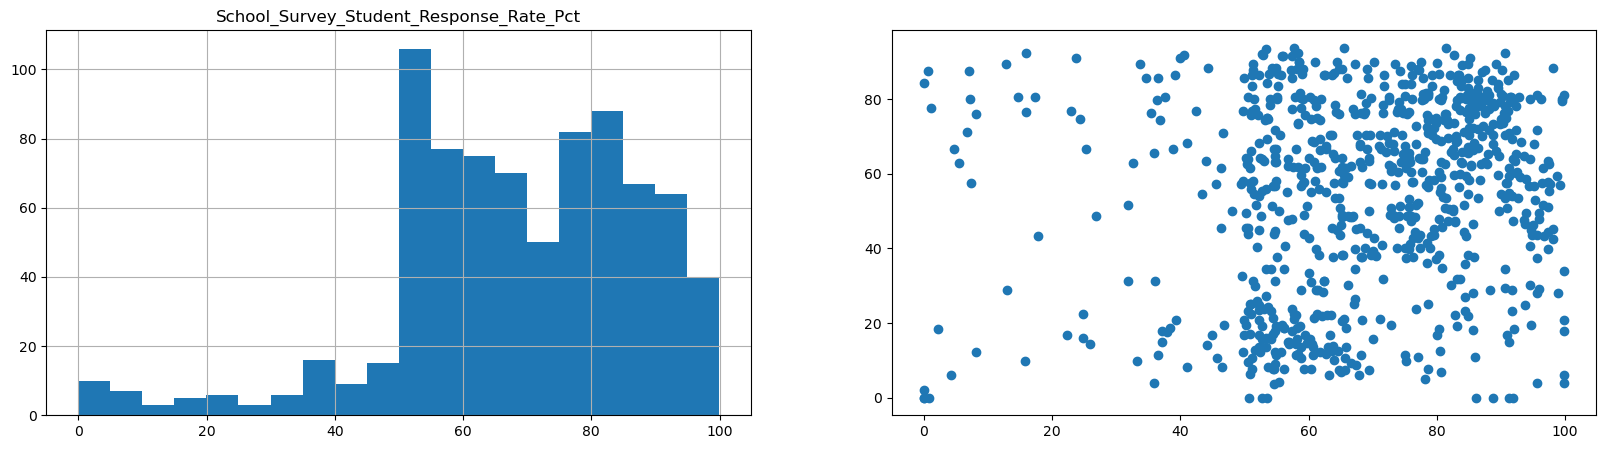

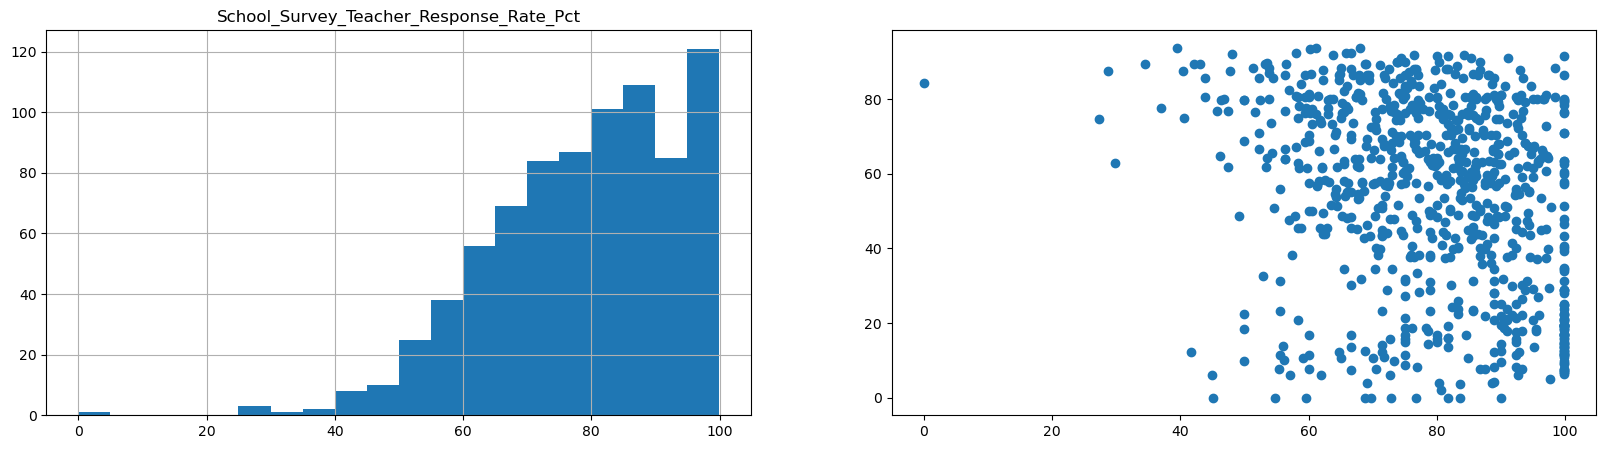

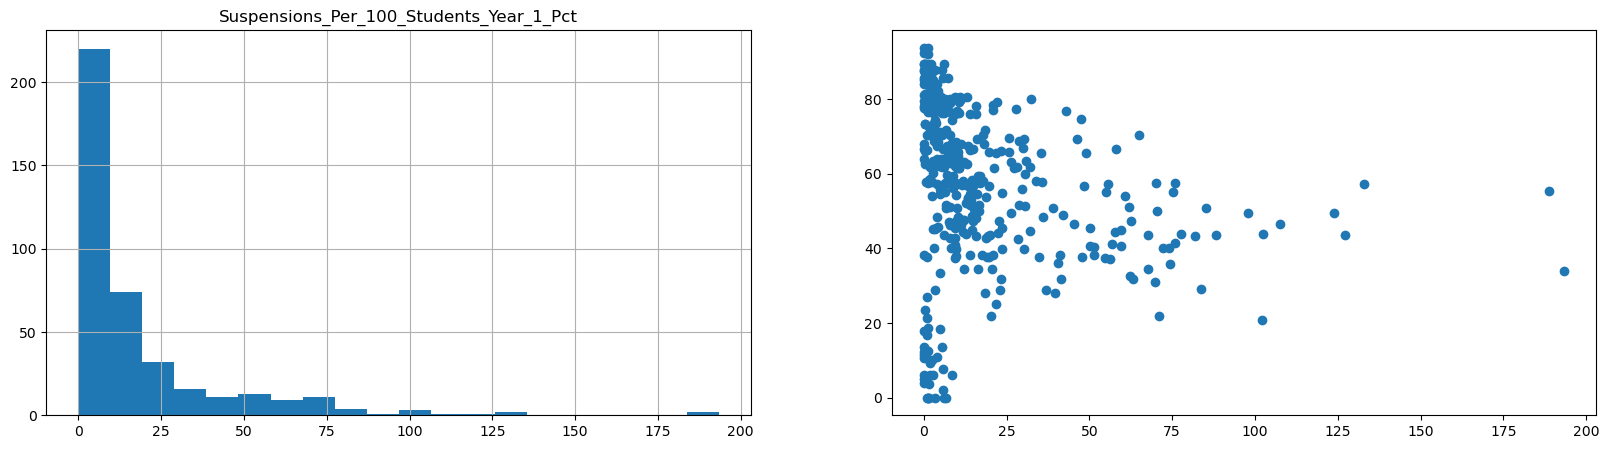

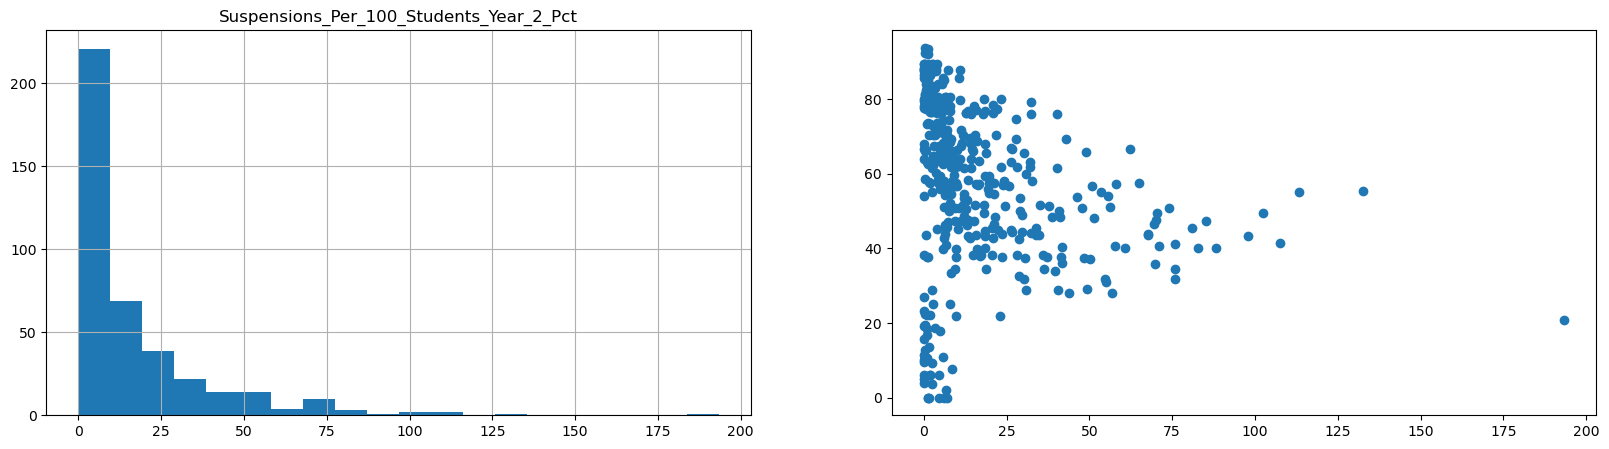

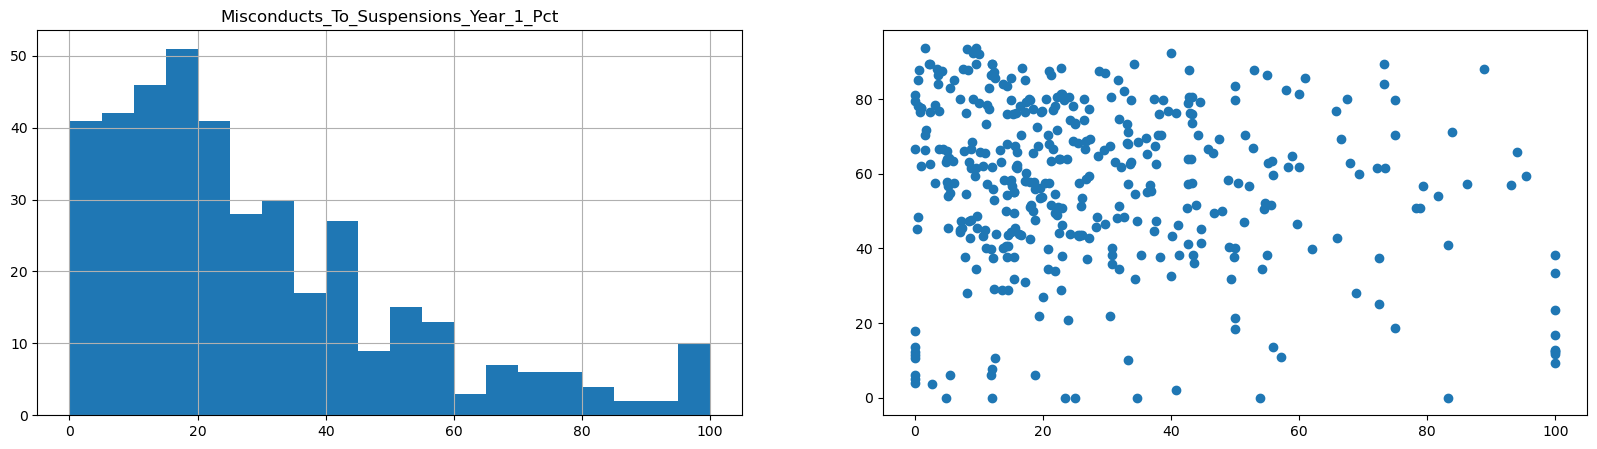

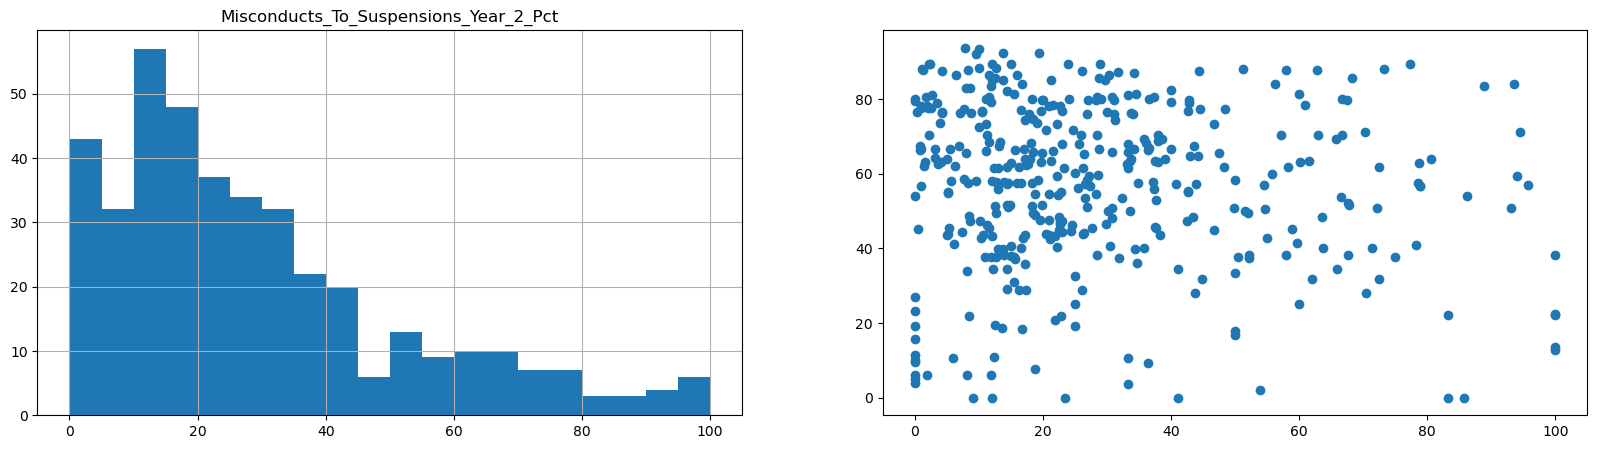

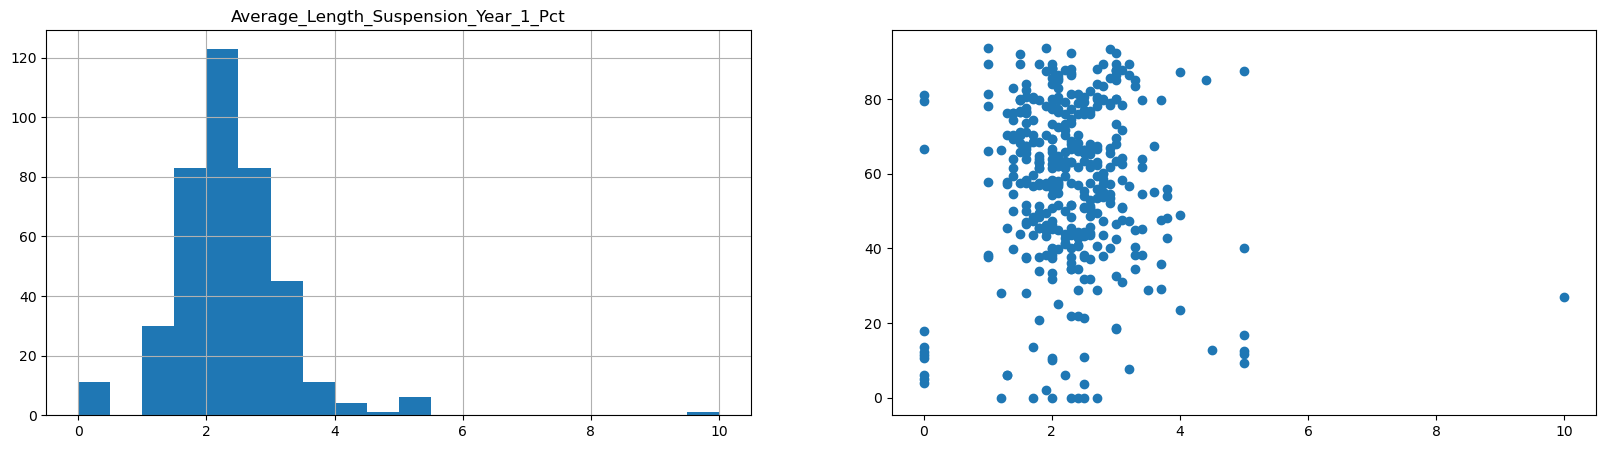

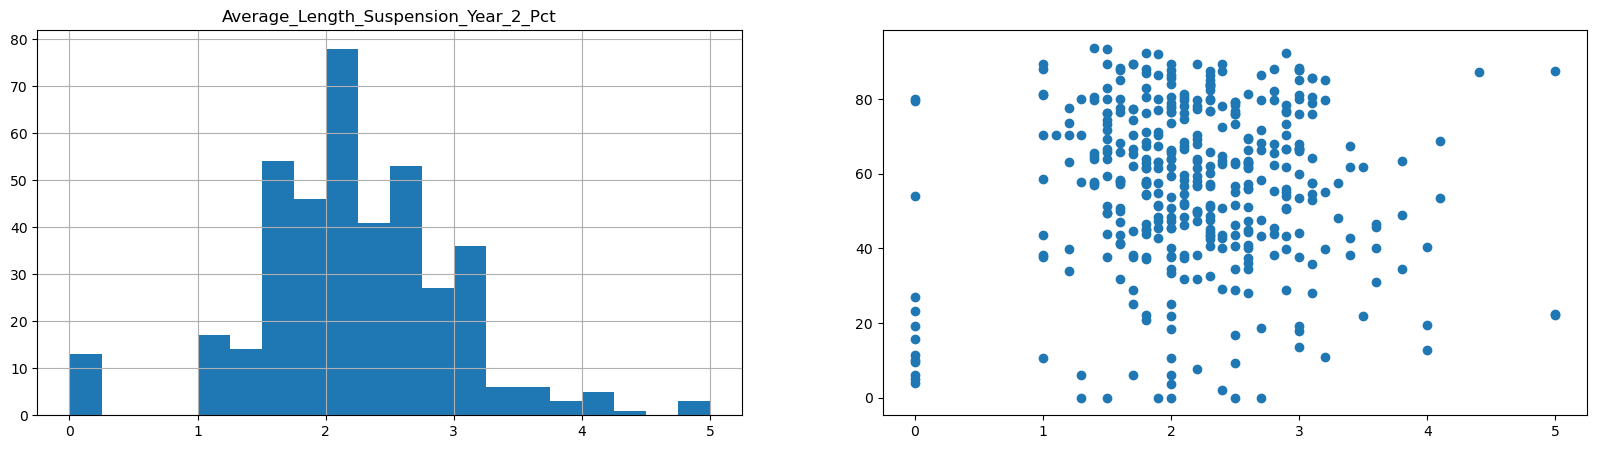

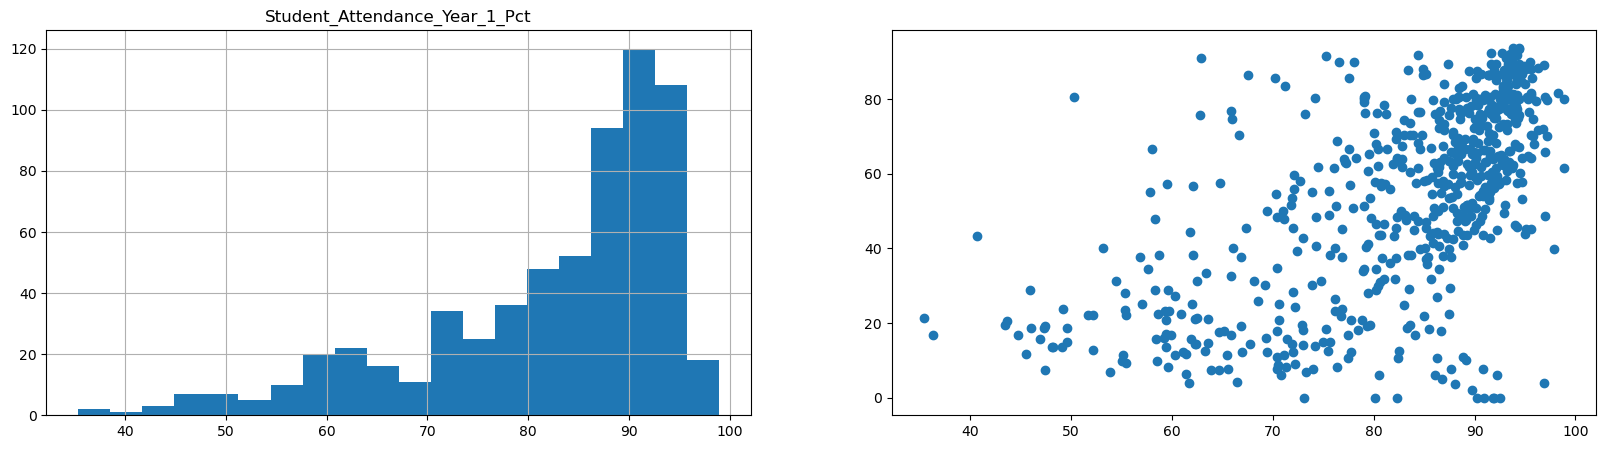

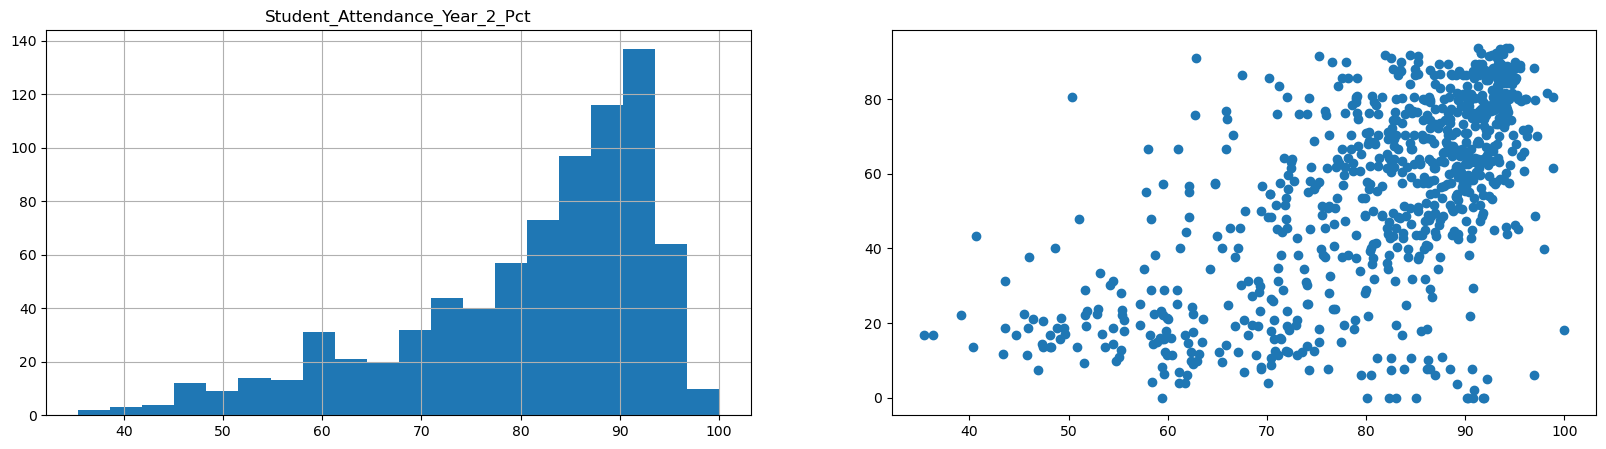

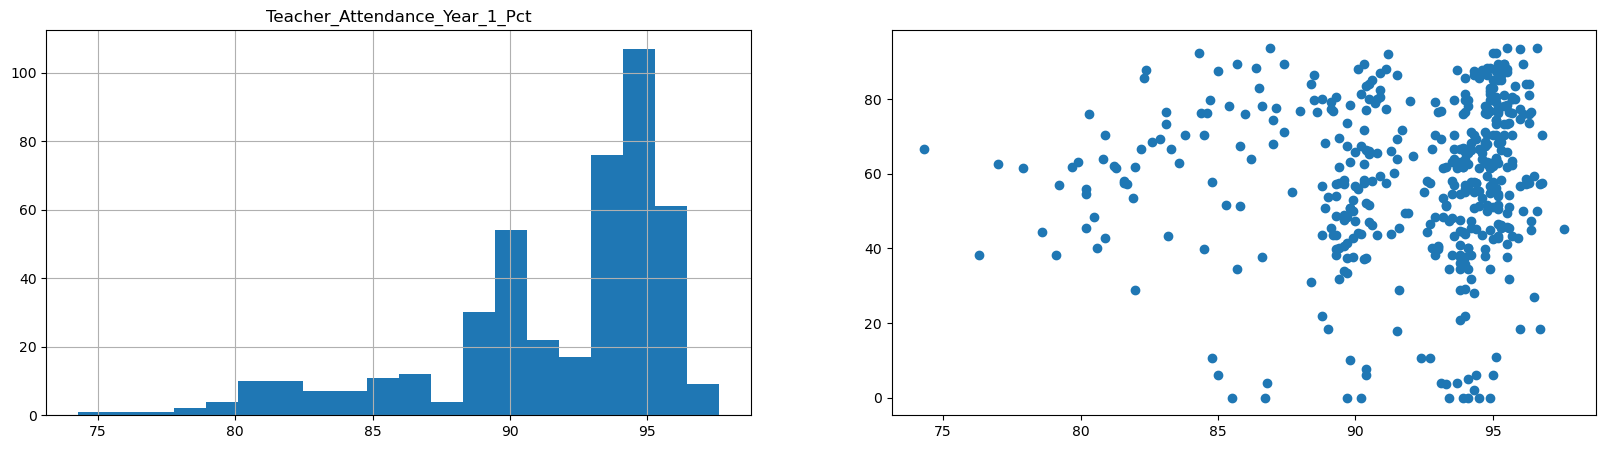

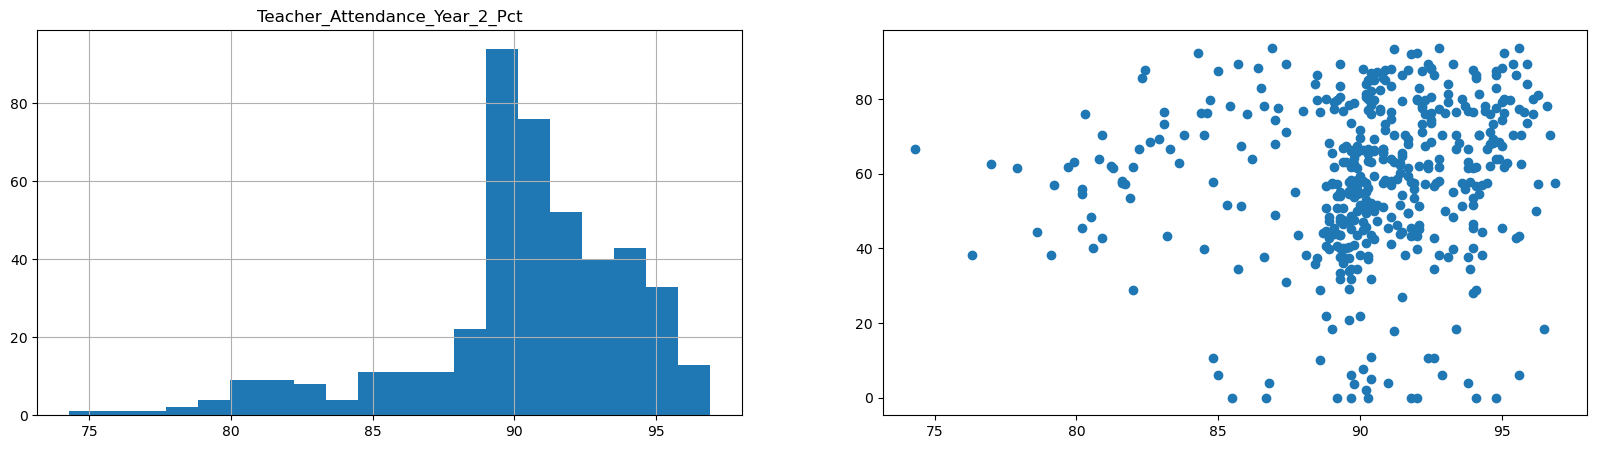

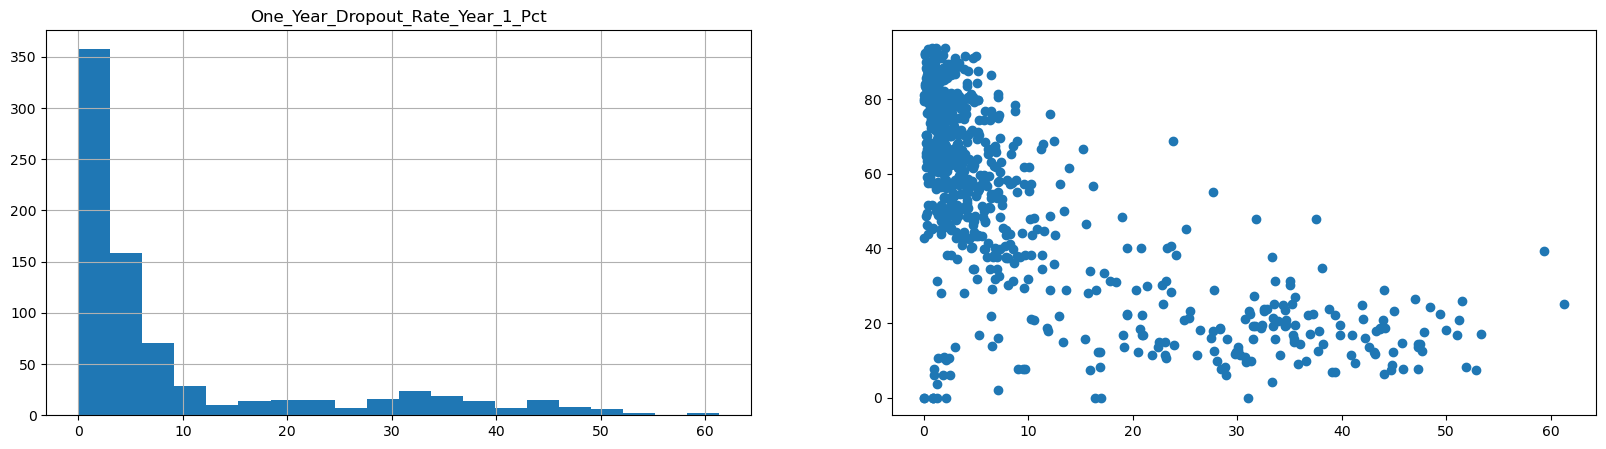

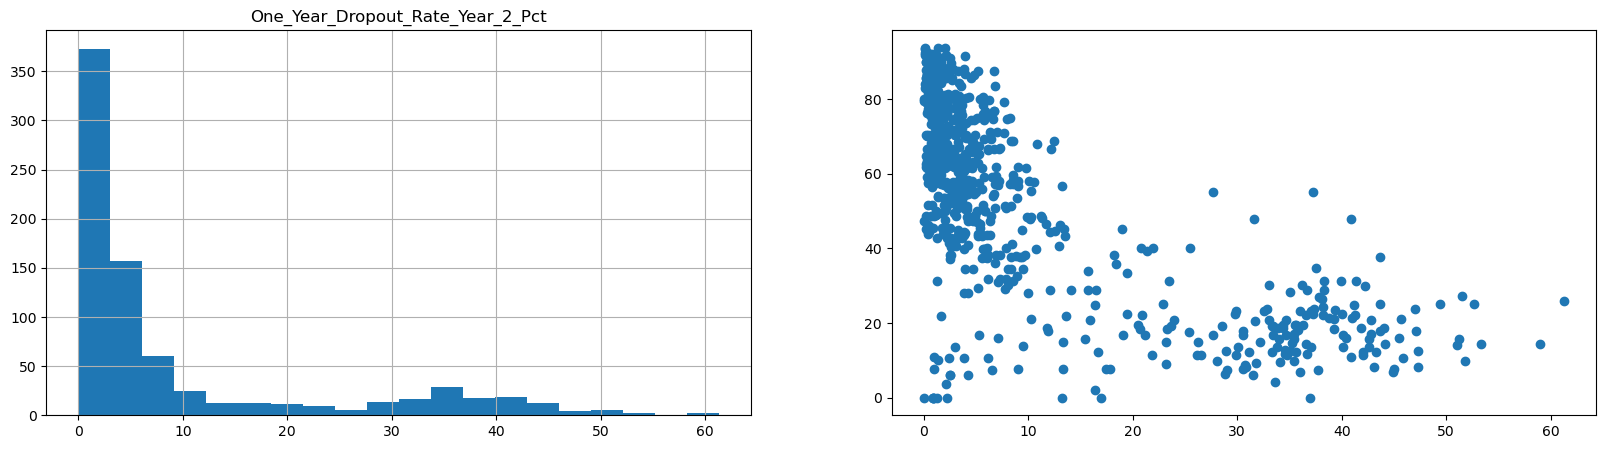

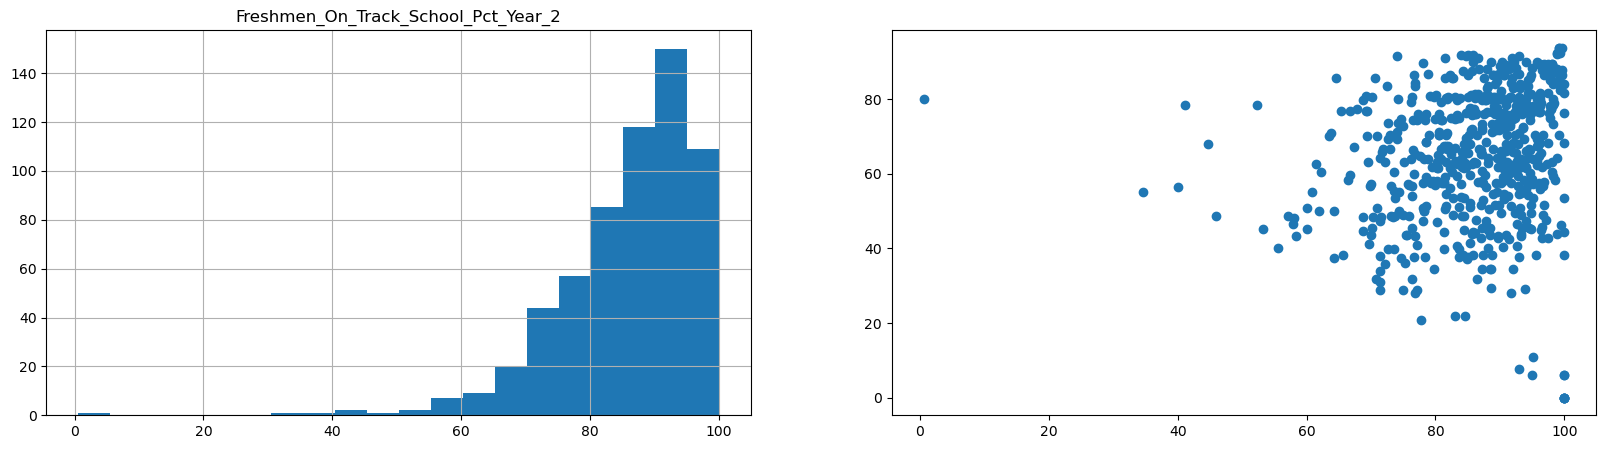

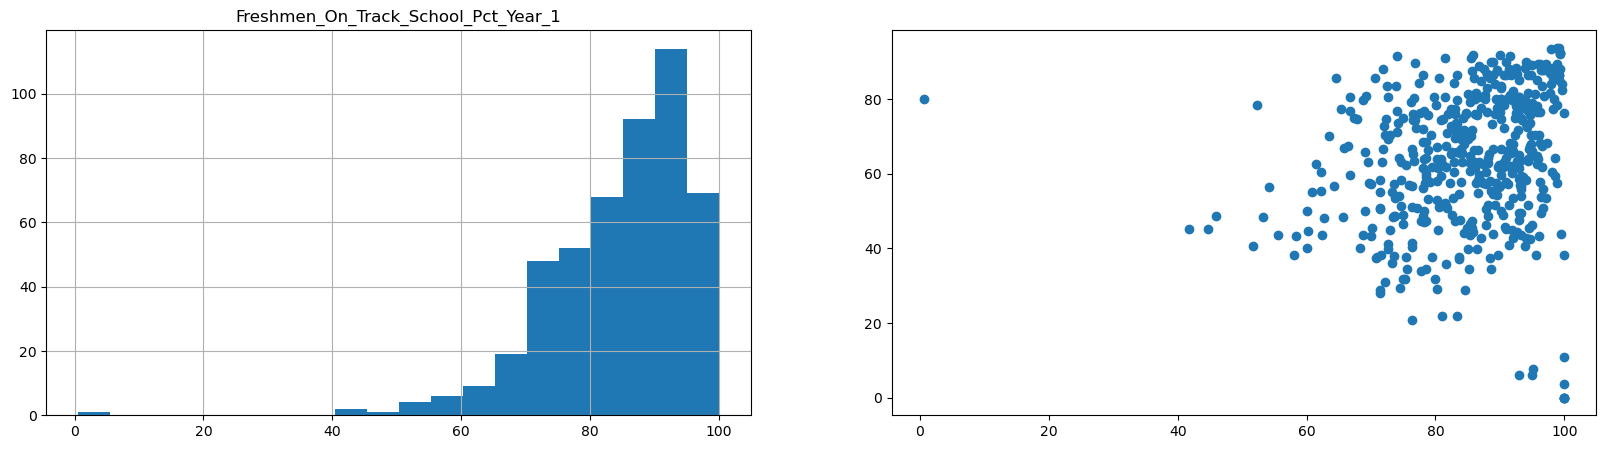

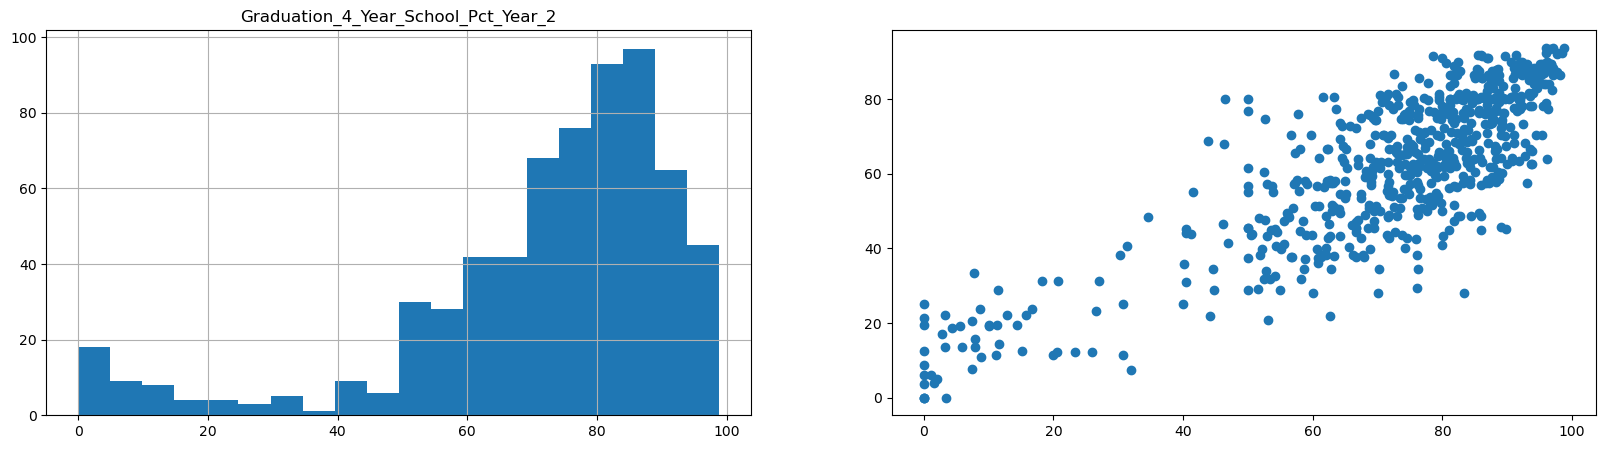

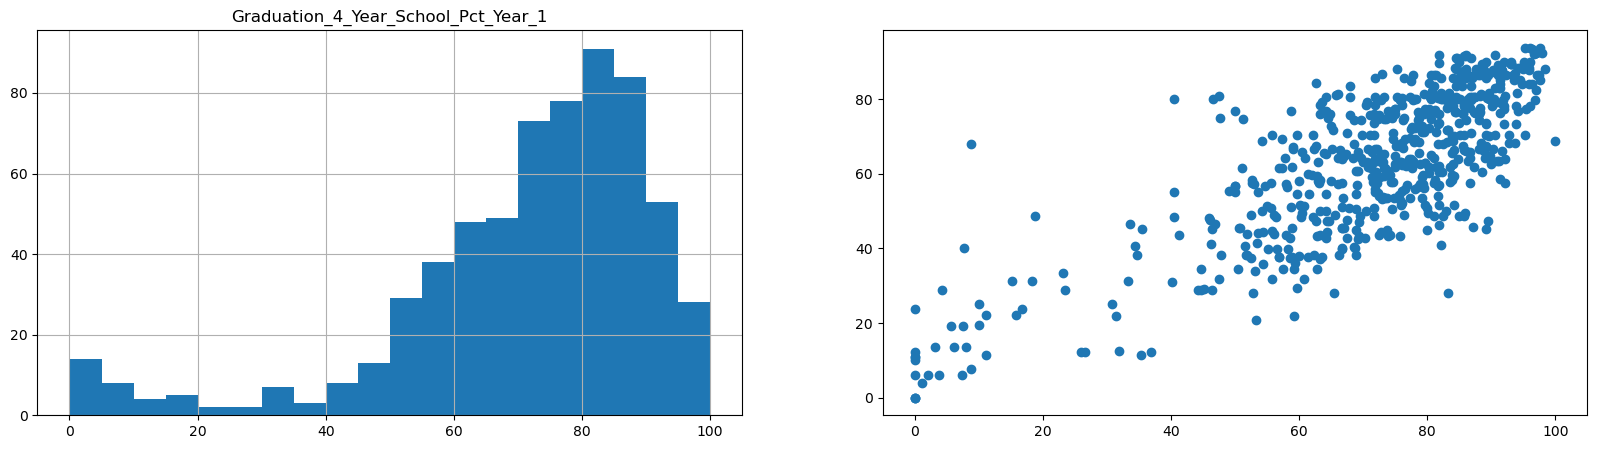

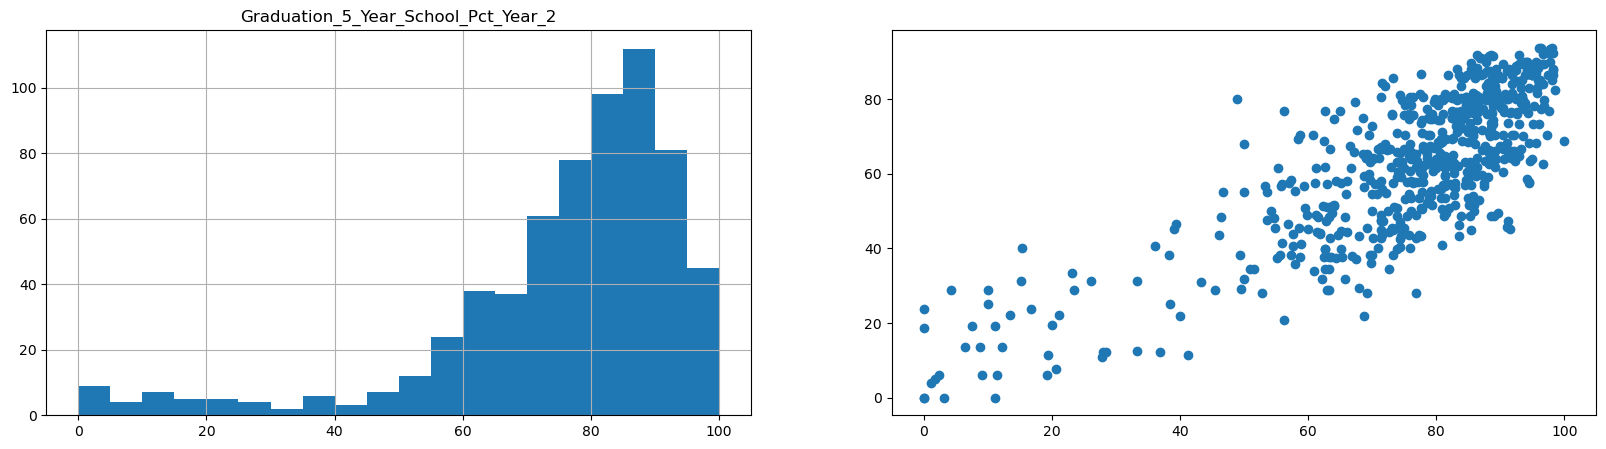

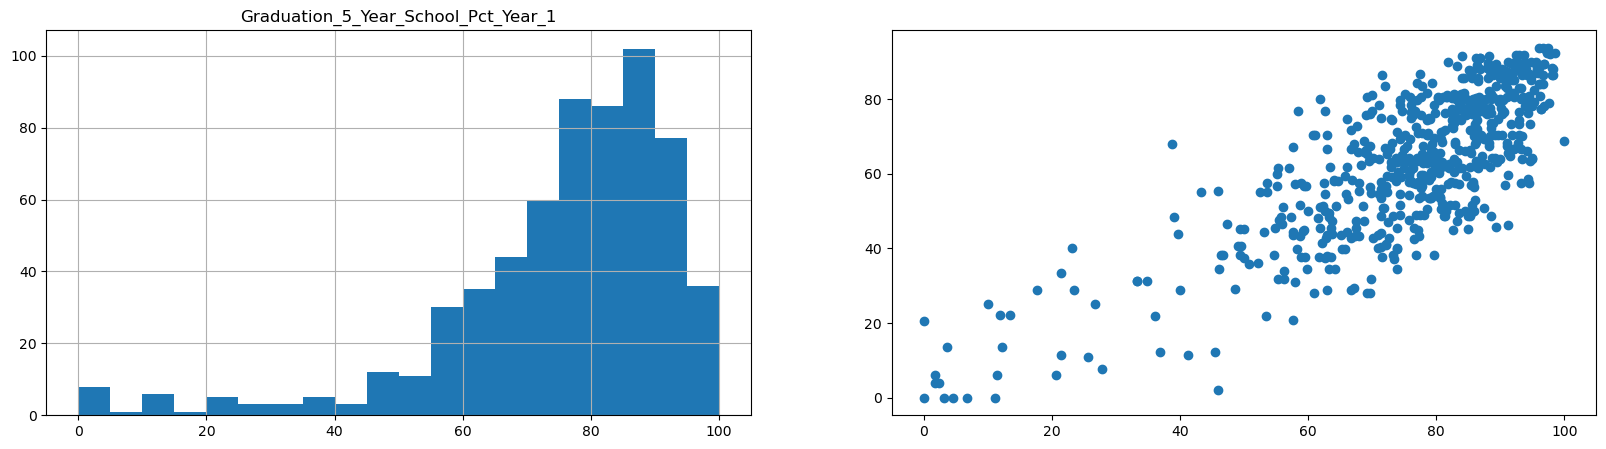

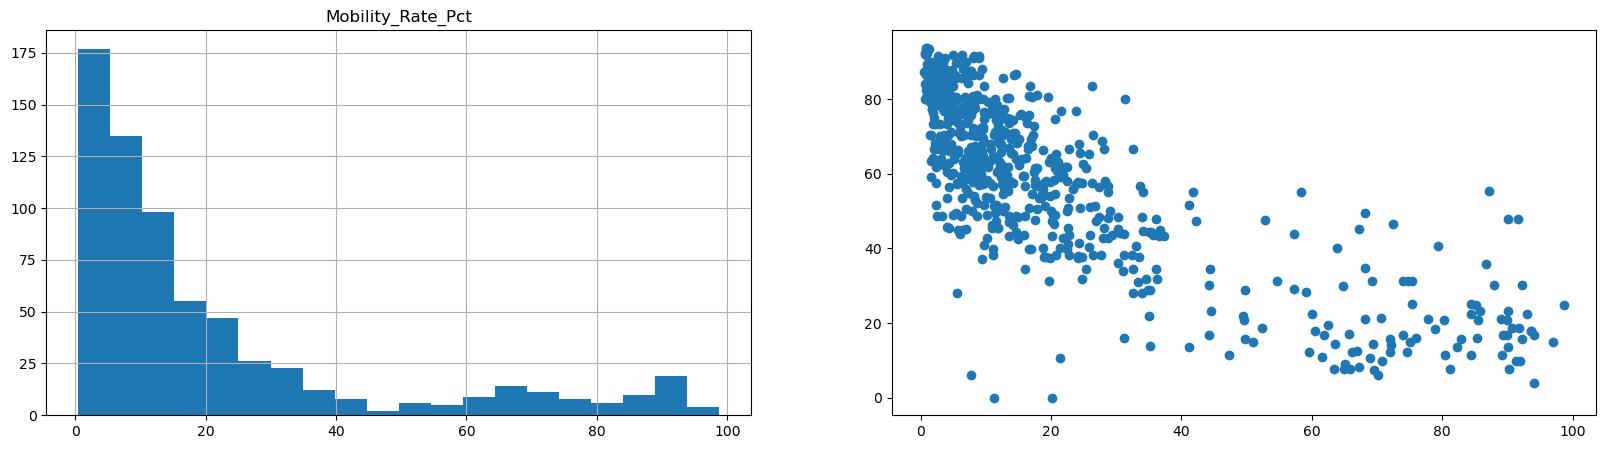

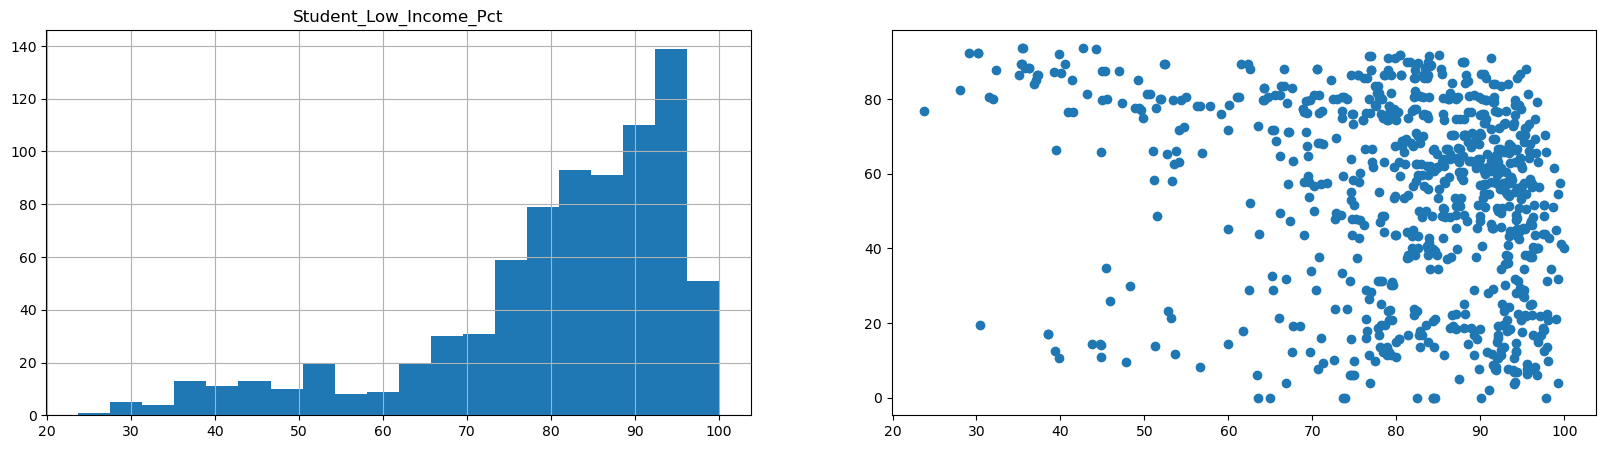

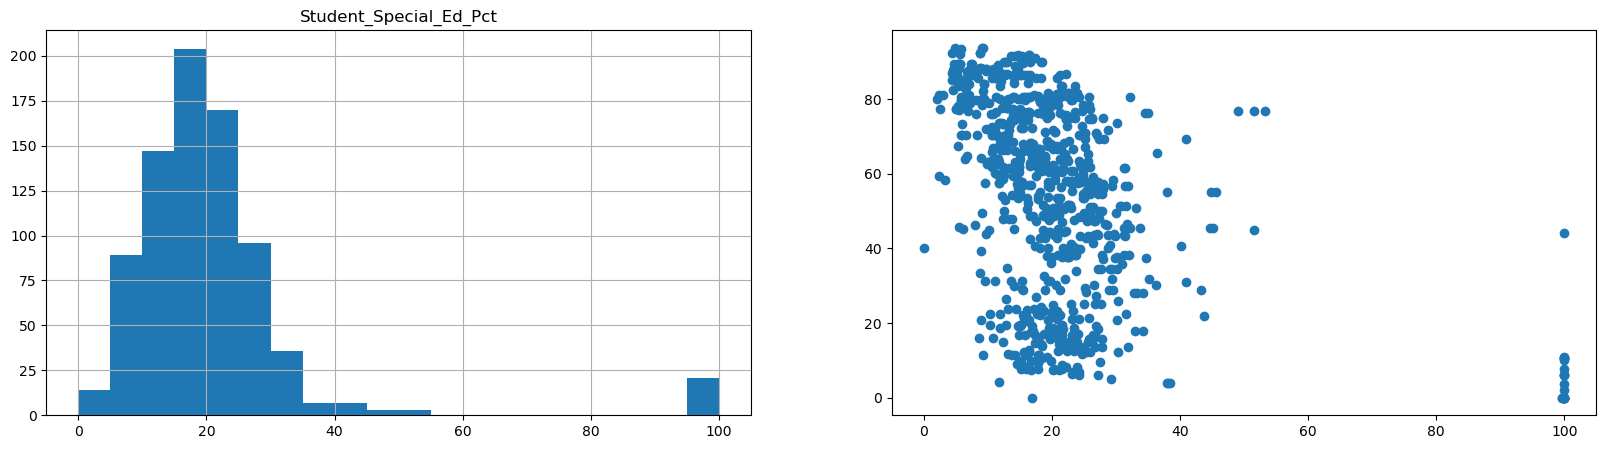

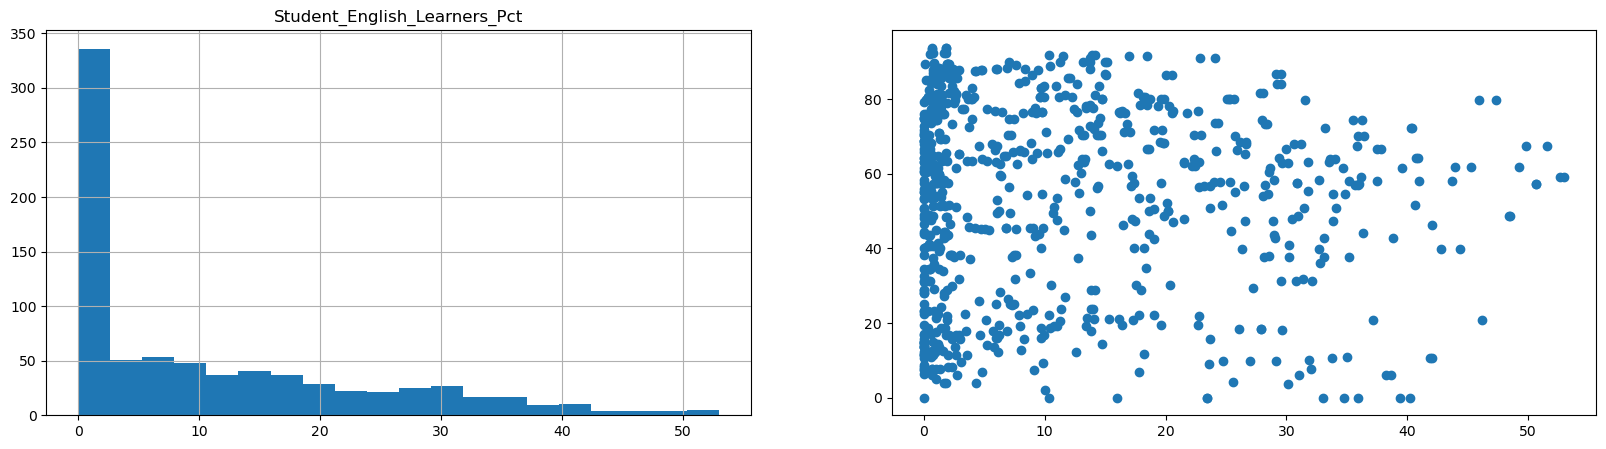

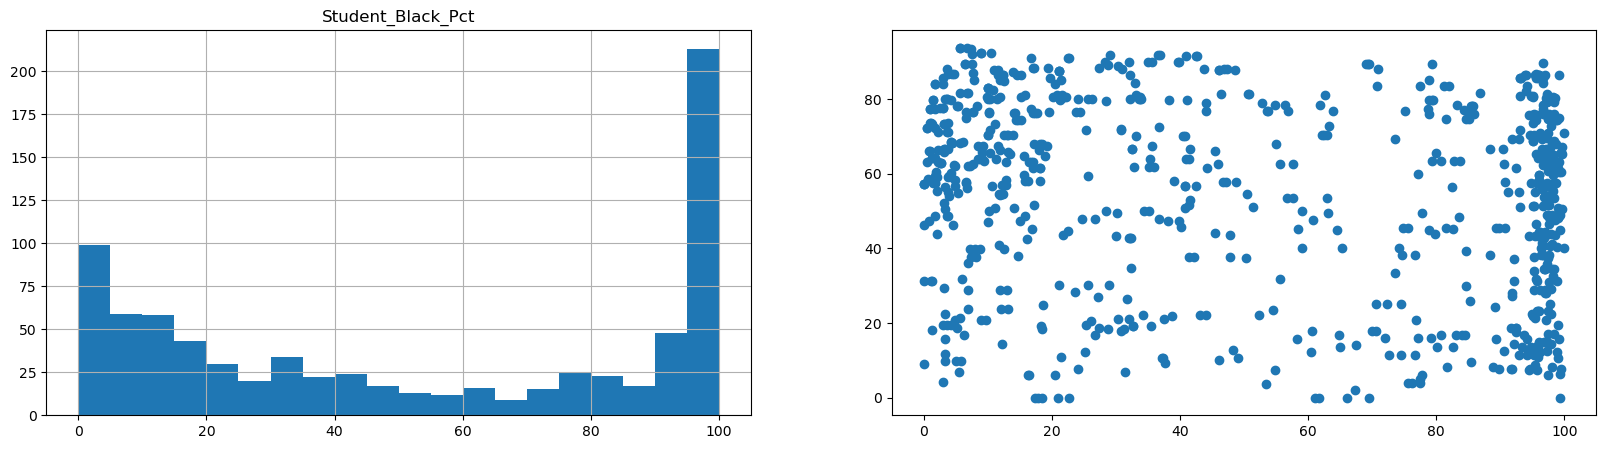

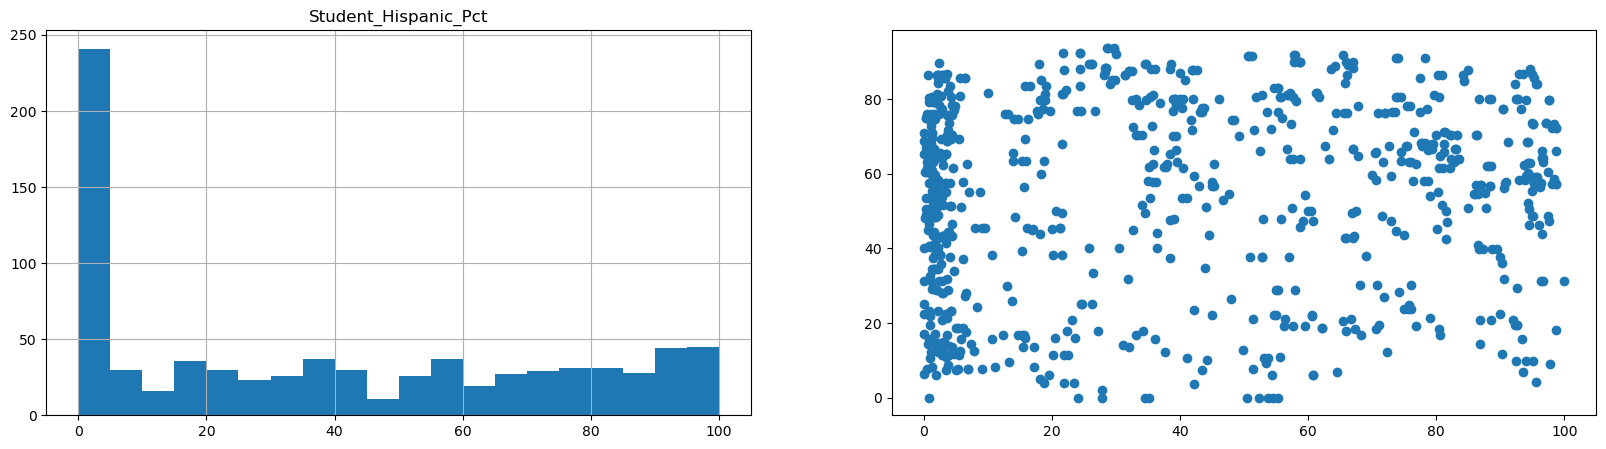

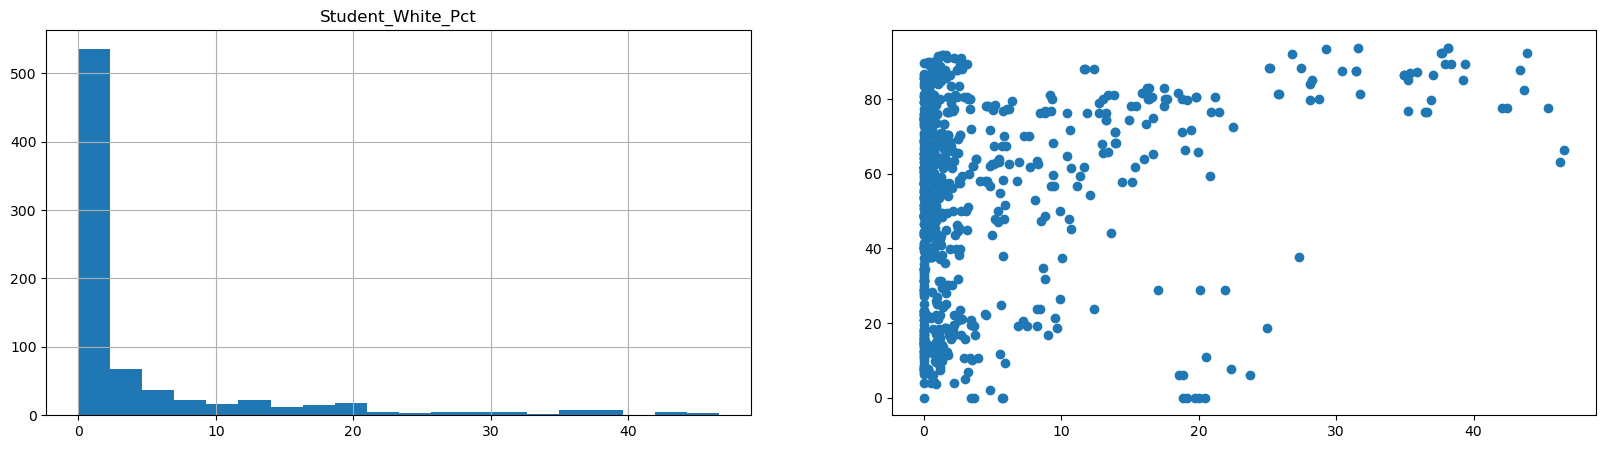

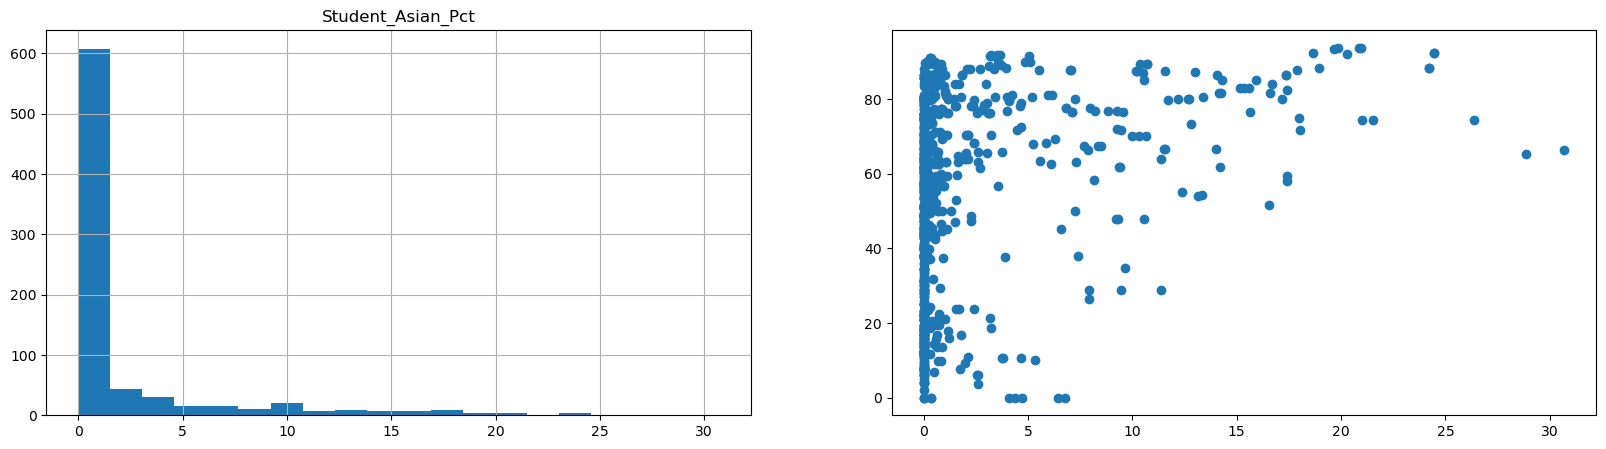

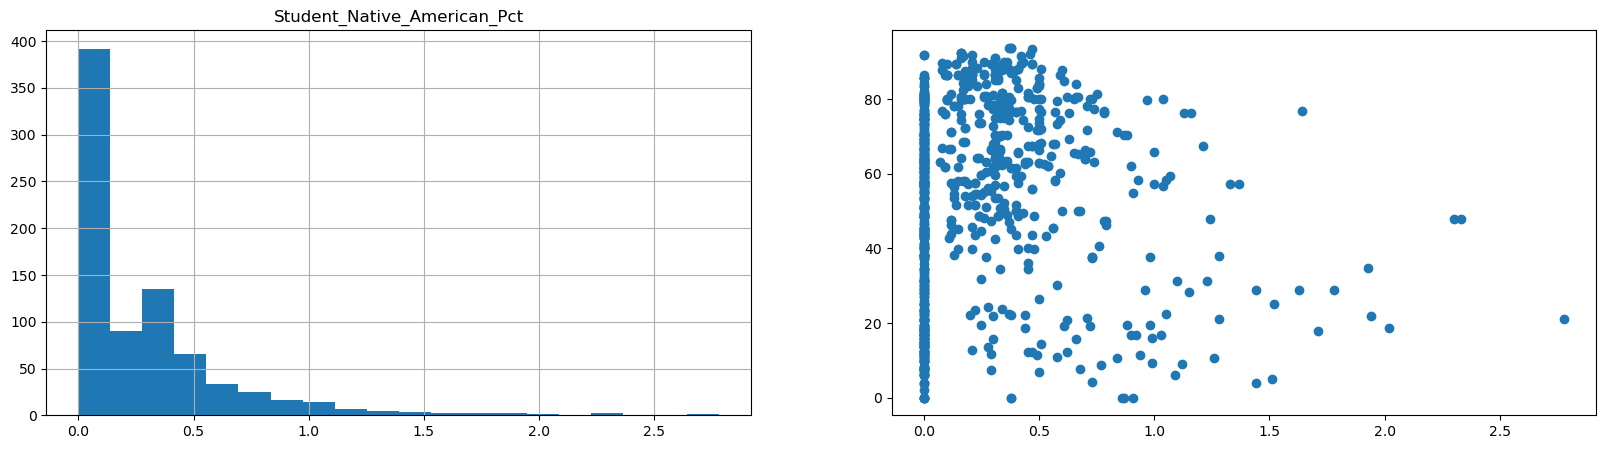

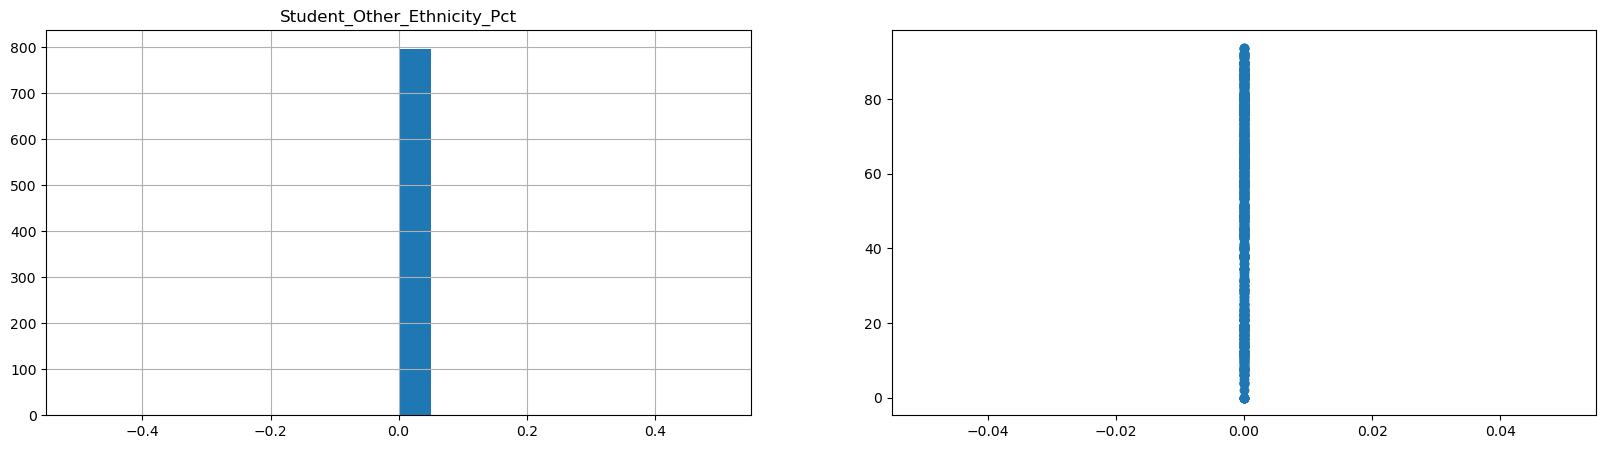

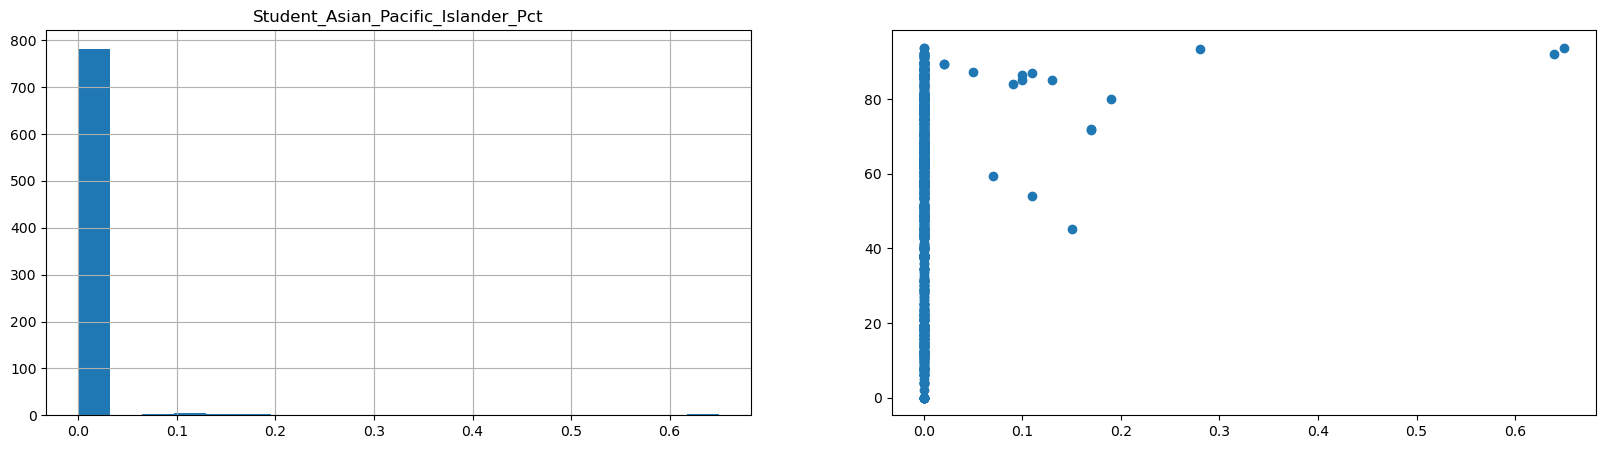

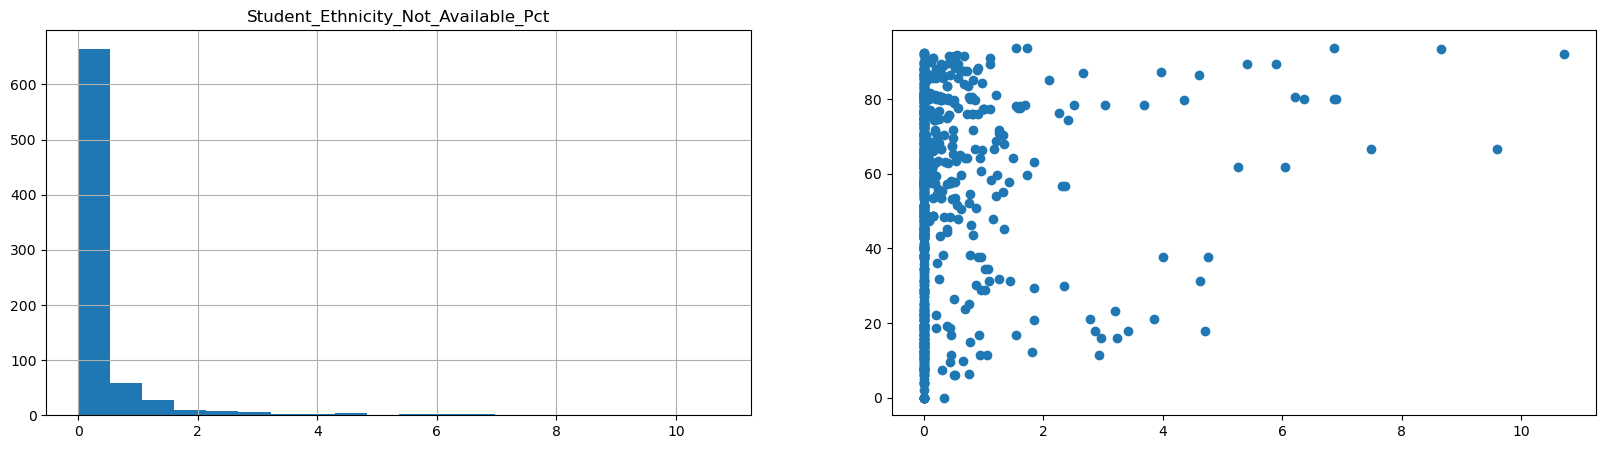

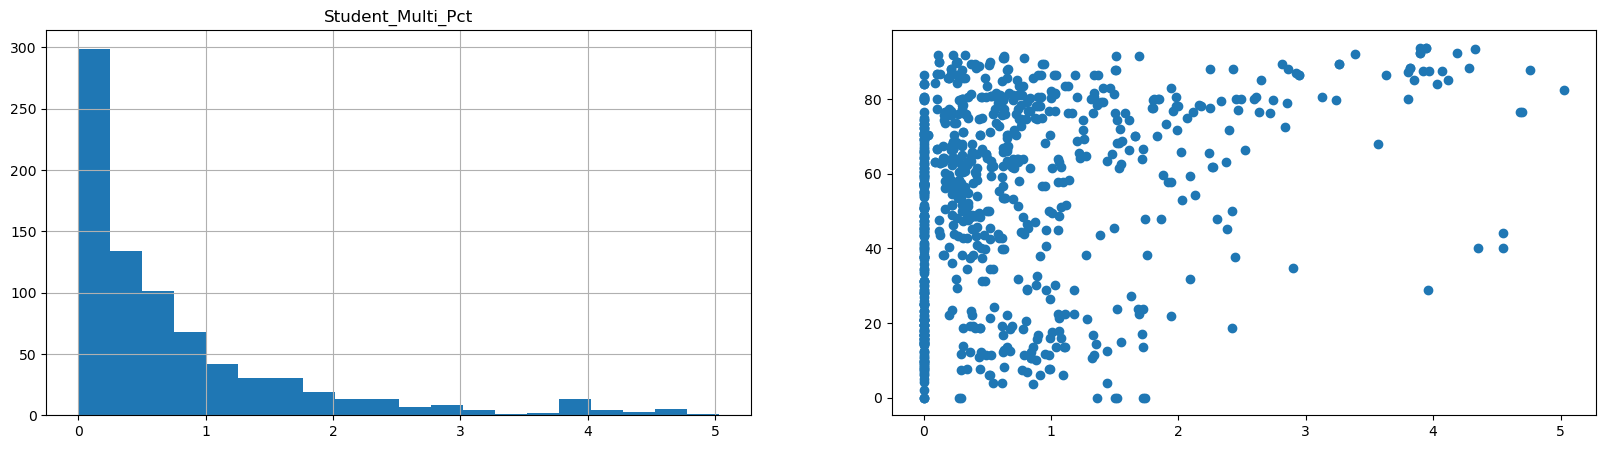

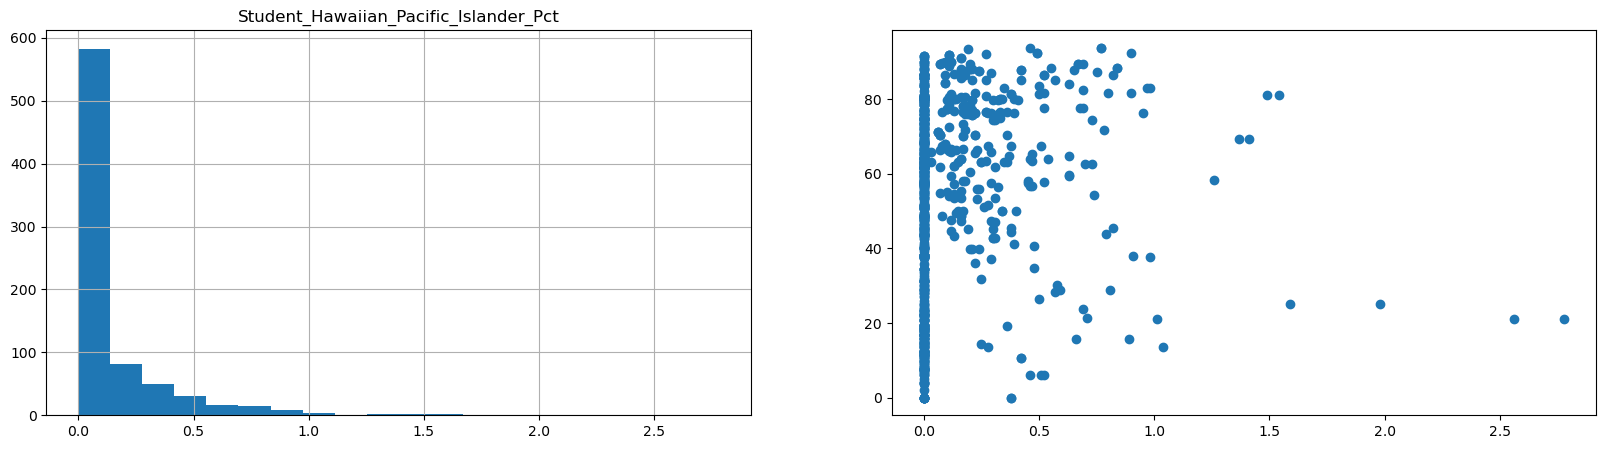

In [24]:
numerical_plot(all_school_reduced, numerical_col)

In [25]:
# drop columns with low variance
all_school_reduced.drop(columns=['Student_Other_Ethnicity_Pct','Student_Asian_Pacific_Islander_Pct'], inplace = True)

## Examin Collinearity

In [26]:
# Examin collinearity
all_school_reduced.corr().style.background_gradient(cmap='coolwarm')

C:\Users\helenli\AppData\Local\Temp\ipykernel_11056\1592868079.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  all_school_reduced.corr().style.background_gradient(cmap='coolwarm')


,Average_ACT_School,College_Enrollment_Rate_School,Graduation_Rate_School,School_Survey_Student_Response_Rate_Pct,School_Survey_Teacher_Response_Rate_Pct,Suspensions_Per_100_Students_Year_1_Pct,Suspensions_Per_100_Students_Year_2_Pct,Misconducts_To_Suspensions_Year_1_Pct,Misconducts_To_Suspensions_Year_2_Pct,Average_Length_Suspension_Year_1_Pct,Average_Length_Suspension_Year_2_Pct,Student_Attendance_Year_1_Pct,Student_Attendance_Year_2_Pct,Teacher_Attendance_Year_1_Pct,Teacher_Attendance_Year_2_Pct,One_Year_Dropout_Rate_Year_1_Pct,One_Year_Dropout_Rate_Year_2_Pct,Freshmen_On_Track_School_Pct_Year_2,Freshmen_On_Track_School_Pct_Year_1,Graduation_4_Year_School_Pct_Year_2,Graduation_4_Year_School_Pct_Year_1,Graduation_5_Year_School_Pct_Year_2,Graduation_5_Year_School_Pct_Year_1,Mobility_Rate_Pct,Student_Low_Income_Pct,Student_Special_Ed_Pct,Student_English_Learners_Pct,Student_Black_Pct,Student_Hispanic_Pct,Student_White_Pct,Student_Asian_Pct,Student_Native_American_Pct,Student_Ethnicity_Not_Available_Pct,Student_Multi_Pct,Student_Hawaiian_Pacific_Islander_Pct
Average_ACT_School,1.000000,0.780433,0.613254,0.262168,-0.309531,-0.416920,-0.427035,-0.194073,-0.059929,-0.094652,-0.137674,0.589870,0.555289,0.398313,0.414701,-0.531690,-0.531024,0.447302,0.500674,0.670038,0.605946,0.613254,0.648619,-0.584099,-0.765985,-0.591598,-0.072644,-0.409783,0.188615,0.609845,0.555433,0.281115,0.450350,0.646174,0.361131
College_Enrollment_Rate_School,0.780433,1.000000,0.810908,0.163257,-0.278076,-0.215947,-0.228084,-0.154775,-0.084459,-0.031742,0.053152,0.608289,0.609922,0.050323,0.099285,-0.697977,-0.706846,0.159661,0.192242,0.818151,0.783940,0.797938,0.791716,-0.788800,-0.227963,-0.446478,-0.039744,-0.199917,0.098642,0.262560,0.312158,-0.005465,0.119522,0.283498,0.117302
Graduation_Rate_School,0.613254,0.810908,1.000000,0.103281,-0.197771,-0.210598,-0.200265,0.033164,0.064497,0.185879,0.105772,0.538272,0.557788,0.078809,0.098774,-0.732498,-0.740339,0.222152,0.272392,0.931621,0.918638,0.954984,0.931219,-0.749102,-0.178625,-0.533996,-0.063063,-0.177241,0.132811,0.108814,0.189525,-0.044223,0.069004,0.167212,0.045094
School_Survey_Student_Response_Rate_Pct,0.262168,0.163257,0.103281,1.000000,0.400482,0.075492,-0.004844,-0.041263,-0.000985,0.045698,-0.040622,0.319197,0.357136,0.055405,0.304840,-0.214446,-0.187421,0.123240,0.069725,0.099747,0.065364,0.057010,0.030714,-0.144158,0.038132,-0.163135,-0.010494,-0.143379,0.142393,0.044585,0.049560,0.072604,-0.106078,0.043841,0.043873
School_Survey_Teacher_Response_Rate_Pct,-0.309531,-0.278076,-0.197771,0.400482,1.000000,0.163591,0.104702,0.074754,0.087816,0.114355,0.002364,-0.129463,-0.150437,0.209241,0.157197,0.296979,0.285006,-0.042146,-0.080647,-0.225147,-0.171823,-0.188635,-0.203424,0.172434,0.234793,-0.068642,-0.017145,-0.003557,0.091632,-0.224777,-0.149296,0.038459,-0.113057,-0.172062,-0.062915
Suspensions_Per_100_Students_Year_1_Pct,-0.416920,-0.215947,-0.210598,0.075492,0.163591,1.000000,0.739227,0.056701,0.006657,0.060626,0.066062,-0.189602,-0.105119,-0.092414,0.055543,0.058465,0.062027,-0.261511,-0.390761,-0.254027,-0.289663,-0.242417,-0.306058,0.487059,0.243546,0.083838,-0.200973,0.439573,-0.340835,-0.294210,-0.248621,-0.189921,-0.134104,-0.275962,-0.136951
Suspensions_Per_100_Students_Year_2_Pct,-0.427035,-0.228084,-0.200265,-0.004844,0.104702,0.739227,1.000000,0.045919,0.112775,0.049948,0.118245,-0.204578,-0.210660,0.023595,-0.127399,0.048061,0.060528,-0.420320,-0.307675,-0.238640,-0.304651,-0.276683,-0.345357,0.508061,0.318398,0.114630,-0.172987,0.461266,-0.357569,-0.314141,-0.258758,-0.206613,-0.108554,-0.286330,-0.181639
Misconducts_To_Suspensions_Year_1_Pct,-0.194073,-0.154775,0.033164,-0.041263,0.074754,0.056701,0.045919,1.000000,0.602994,0.224876,0.216590,-0.243238,-0.213731,-0.035242,0.098939,0.219364,0.271247,-0.026826,-0.001255,-0.006103,-0.024769,0.009974,-0.058413,-0.034273,0.091629,-0.012404,-0.044837,0.065197,0.011544,-0.128287,-0.168593,-0.050397,-0.157046,-0.183628,-0.153799
Misco

In [27]:
# drop collinear columns
all_school_dropCollinear = all_school_reduced.drop(columns=['Student_Attendance_Year_2_Pct','One_Year_Dropout_Rate_Year_2_Pct','Graduation_4_Year_School_Pct_Year_1','Graduation_5_Year_School_Pct_Year_2',
                                 'Graduation_5_Year_School_Pct_Year_1','Mobility_Rate_Pct','Student_Hispanic_Pct','Student_Asian_Pct','Student_Multi_Pct'])

In [28]:
all_school_dropCollinear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 803 entries, 2 to 170
Data columns (total 40 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Bilingual_Services                       712 non-null    object 
 1   Refugee_Services                         591 non-null    object 
 2   Title_1_Eligible                         771 non-null    object 
 3   Average_ACT_School                       152 non-null    float64
 4   College_Enrollment_Rate_School           803 non-null    float64
 5   Graduation_Rate_School                   650 non-null    float64
 6   Overall_Rating                           803 non-null    object 
 7   Student_Growth_Rating                    366 non-null    object 
 8   Student_Attainment_Rating                455 non-null    object 
 9   Culture_Climate_Rating                   772 non-null    object 
 10  School_Survey_Student_Response_Rate_Pct  799 non-n

## Check missing values

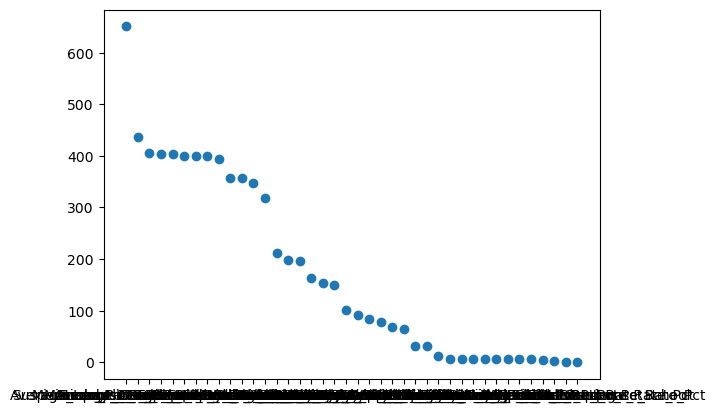

In [29]:
is_na_col =all_school_dropCollinear.isna().sum().sort_values(ascending=False)
is_na_df = pd.DataFrame(is_na_col, columns=['no_of_na'])
is_na_df.shape
is_na_df['na_pct']=is_na_df['no_of_na']/all_school_reduced.shape[0]
#view the missing data condition
plt.scatter( is_na_df.index, is_na_df.no_of_na)

In [30]:
is_na_df

,no_of_na,na_pct
Average_ACT_School,651,0.810710
Student_Growth_Rating,437,0.544209
Average_Length_Suspension_Year_1_Pct,405,0.504359
Suspensions_Per_100_Students_Year_1_Pct,403,0.501868
Misconducts_To_Suspensions_Year_1_Pct,403,0.501868
Misconducts_To_Suspensions_Year_2_Pct,400,0.498132
Average_Length_Suspension_Year_2_Pct,400,0.498132
Suspensions_Per_100_Students_Year_2_Pct,400,0.498132
Creative_School_Certification,393,0.489415
Teacher_Attendance_Year_2_Pct,358,0.445828


## Drop features which have more than 80% of missing data

Tried to raised by bar of droping features with missing value over 80%. 

In [31]:
# drop features which has over 25% of missing data
drop_features = is_na_df[is_na_df.na_pct>0.80].index.tolist()

In [32]:
all_school_dropna1 = all_school_dropCollinear.drop(columns=drop_features)

In [33]:
all_school_dropna1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 803 entries, 2 to 170
Data columns (total 39 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Bilingual_Services                       712 non-null    object 
 1   Refugee_Services                         591 non-null    object 
 2   Title_1_Eligible                         771 non-null    object 
 3   College_Enrollment_Rate_School           803 non-null    float64
 4   Graduation_Rate_School                   650 non-null    float64
 5   Overall_Rating                           803 non-null    object 
 6   Student_Growth_Rating                    366 non-null    object 
 7   Student_Attainment_Rating                455 non-null    object 
 8   Culture_Climate_Rating                   772 non-null    object 
 9   School_Survey_Student_Response_Rate_Pct  799 non-null    float64
 10  School_Survey_Teacher_Response_Rate_Pct  800 non-n

# Preprocessing

In [34]:
X = all_school_dropna1.drop(columns= ['College_Enrollment_Rate_School'])
y = all_school_dropna1['College_Enrollment_Rate_School']

In [35]:
#check the categorical and numerical columns
categorial_col = [col for col in X.columns.values if X[col].dtype == 'object']
numerical_col = [col for col in X.columns.values if X[col].dtype == 'float64']

In [36]:
X.shape

(803, 38)

In [37]:
categorial_col

['Bilingual_Services',
 'Refugee_Services',
 'Title_1_Eligible',
 'Overall_Rating',
 'Student_Growth_Rating',
 'Student_Attainment_Rating',
 'Culture_Climate_Rating',
 'Creative_School_Certification',
 'School_Survey_Involved_Families',
 'School_Survey_Supportive_Environment',
 'School_Survey_Ambitious_Instruction',
 'School_Survey_Effective_Leaders',
 'School_Survey_Collaborative_Teachers',
 'School_Survey_Safety']

In [38]:
numerical_col

['Graduation_Rate_School',
 'School_Survey_Student_Response_Rate_Pct',
 'School_Survey_Teacher_Response_Rate_Pct',
 'Suspensions_Per_100_Students_Year_1_Pct',
 'Suspensions_Per_100_Students_Year_2_Pct',
 'Misconducts_To_Suspensions_Year_1_Pct',
 'Misconducts_To_Suspensions_Year_2_Pct',
 'Average_Length_Suspension_Year_1_Pct',
 'Average_Length_Suspension_Year_2_Pct',
 'Student_Attendance_Year_1_Pct',
 'Teacher_Attendance_Year_1_Pct',
 'Teacher_Attendance_Year_2_Pct',
 'One_Year_Dropout_Rate_Year_1_Pct',
 'Freshmen_On_Track_School_Pct_Year_2',
 'Freshmen_On_Track_School_Pct_Year_1',
 'Graduation_4_Year_School_Pct_Year_2',
 'Student_Low_Income_Pct',
 'Student_Special_Ed_Pct',
 'Student_English_Learners_Pct',
 'Student_Black_Pct',
 'Student_White_Pct',
 'Student_Native_American_Pct',
 'Student_Ethnicity_Not_Available_Pct',
 'Student_Hawaiian_Pacific_Islander_Pct']

In [39]:
# Convert training data and testing data to numpy array
X_num_array = X[numerical_col].to_numpy()

In [40]:
# split for pipeline
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size = 0.3, random_state = 42)

## Dealing with Categorical values

In [368]:
# Dealing with Categorical values
# OrdinalEncoder does not work with missing data, use factorize to encode categorical data
X_cat = X[categorial_col].apply(lambda x:x.factorize()[0]).replace(-1,np.NaN).to_numpy()

In [369]:
X_cat_df = pd.DataFrame(X_cat, columns = categorial_col)

In [370]:
X_cat_df

,Bilingual_Services,Refugee_Services,Title_1_Eligible,Overall_Rating,Student_Growth_Rating,Student_Attainment_Rating,Culture_Climate_Rating,Creative_School_Certification,School_Survey_Involved_Families,School_Survey_Supportive_Environment,School_Survey_Ambitious_Instruction,School_Survey_Effective_Leaders,School_Survey_Collaborative_Teachers,School_Survey_Safety
0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NaN,NaN,0.0,1.0,NaN,NaN,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
2,0.0,0.0,0.0,2.0,0.0,1.0,1.0,NaN,2.0,0.0,1.0,1.0,2.0,1.0
3,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,2.0,1.0,2.0,1.0
4,1.0,0.0,0.0,0.0,1.0,1.0,3.0,1.0,3.0,0.0,3.0,2.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798,1.0,0.0,0.0,2.0,NaN,NaN,3.0,NaN,3.0,2.0,1.0,1.0,2.0,0.0
799,NaN,NaN,0.0,0.0,NaN,NaN,3.0,NaN,2.0,0.0,3.0,4.0,3.0,0.0
800,1.0,1.0,0.0,5.0,NaN,NaN,4.0,NaN,NaN,2.0,2.0,0.0,2.0,0.0
801,NaN,NaN,0.0,2.0,NaN,NaN,1.0,NaN,2.0,0.0,1.0,1.0,2.0,0.0


In [371]:
df1 = X[categorial_col].to_numpy()

In [372]:
df1 = pd.DataFrame(df1,columns=categorial_col)

In [373]:
df1

,Bilingual_Services,Refugee_Services,Title_1_Eligible,Overall_Rating,Student_Growth_Rating,Student_Attainment_Rating,Culture_Climate_Rating,Creative_School_Certification,School_Survey_Involved_Families,School_Survey_Supportive_Environment,School_Survey_Ambitious_Instruction,School_Survey_Effective_Leaders,School_Survey_Collaborative_Teachers,School_Survey_Safety
0,NaN,N,Y,Level 2,NaN,FAR BELOW AVERAGE,NOT YET ORGANIZED,EMERGING,WEAK,NEUTRAL,WEAK,WEAK,WEAK,WEAK
1,NaN,NaN,Y,Inability to Rate,NaN,NaN,ORGANIZED,DEVELOPING,VERY WEAK,NEUTRAL,STRONG,NEUTRAL,STRONG,WEAK
2,N,N,Y,Level 1,AVERAGE,BELOW AVERAGE,ORGANIZED,NaN,STRONG,NEUTRAL,STRONG,NEUTRAL,NEUTRAL,VERY WEAK
3,N,N,Y,Level 2,BELOW AVERAGE,FAR BELOW AVERAGE,PARTIALLY ORGANIZED,DEVELOPING,VERY WEAK,NEUTRAL,NEUTRAL,NEUTRAL,NEUTRAL,VERY WEAK
4,Y,N,Y,Level 2,BELOW AVERAGE,BELOW AVERAGE,WELL ORGANIZED,DEVELOPING,VERY STRONG,NEUTRAL,VERY STRONG,STRONG,VERY STRONG,VERY WEAK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798,Y,N,Y,Level 1,NaN,NaN,WELL ORGANIZED,NaN,VERY STRONG,STRONG,STRONG,NEUTRAL,NEUTRAL,WEAK
799,NaN,NaN,Y,Level 2,NaN,NaN,WELL ORGANIZED,NaN,STRONG,NEUTRAL,VERY STRONG,VERY STRONG,VERY STRONG,WEAK
800,Y,Y,Y,Level 2+,NaN,NaN,MODERATELY ORGANIZED,NaN,NaN,STRONG,NEUTRAL,WEAK,NEUTRAL,WEAK
801,NaN,NaN,Y,Level 1,NaN,NaN,ORGANIZED,NaN,STRONG,NEUTRAL,STRONG,NEUTRAL,NEUTRAL,WEAK


In [378]:
import string
def lower_to_capital(dict_info):
    new_dict = {}
    for i,j in dict_info.items():
        x = string.capwords(i,'_')
        new_dict[x]=j
    return new_dict

In [379]:
# Categorical data mapping to values
def mapping(df1, df2):
    col1 = df1.columns.values
    df2=df2.rename(columns=str.lower)
    col2 =df2.columns.values
    lst =[]
    d = {}
    for i in range(len(col1)):
        d1 = df1.iloc[:,i]
        d2 = df2.iloc[:,i]
        temp_df = pd.DataFrame(list(zip(d1,d2)), columns=[col1[i],col2[i]])
        temp_df1 = temp_df.groupby(by=col1[i]).mean()
        d = temp_df1.to_dict()
        d_cap = lower_to_capital(d)
        lst.append(d_cap)
    return lst

In [380]:
mapped = mapping(df1,X_cat_df)

In [381]:
mapped

[{'Bilingual_Services': {'N': 0.0, 'Y': 1.0}},
 {'Refugee_Services': {'N': 0.0, 'Y': 1.0}},
 {'Title_1_Eligible': {'N': 1.0, 'Y': 0.0}},
 {'Overall_Rating': {'Inability to Rate': 1.0,
   'Level 1': 2.0,
   'Level 1+': 4.0,
   'Level 2': 0.0,
   'Level 2+': 5.0,
   'Level 3': 3.0}},
 {'Student_Growth_Rating': {'ABOVE AVERAGE': 3.0,
   'AVERAGE': 0.0,
   'BELOW AVERAGE': 1.0,
   'FAR ABOVE AVERAGE': 4.0,
   'FAR BELOW AVERAGE': 2.0}},
 {'Student_Attainment_Rating': {'ABOVE AVERAGE': 2.0,
   'AVERAGE': 3.0,
   'BELOW AVERAGE': 1.0,
   'FAR ABOVE AVERAGE': 4.0,
   'FAR BELOW AVERAGE': 0.0}},
 {'Culture_Climate_Rating': {'MODERATELY ORGANIZED': 4.0,
   'NOT YET ORGANIZED': 0.0,
   'ORGANIZED': 1.0,
   'PARTIALLY ORGANIZED': 2.0,
   'WELL ORGANIZED': 3.0}},
 {'Creative_School_Certification': {'DEVELOPING': 1.0,
   'EMERGING': 0.0,
   'EXCELLING': 2.0,
   'STRONG': 3.0}},
 {'School_Survey_Involved_Families': {'NEUTRAL': 4.0,
   'STRONG': 2.0,
   'VERY STRONG': 3.0,
   'VERY WEAK': 1.0,
   'WE

## Using Simple imputer to predict categorical missing values

In [50]:
from sklearn.impute import SimpleImputer
simpleimputer = SimpleImputer(missing_values=np.NaN, strategy='most_frequent' )
X_cat_imputed = simpleimputer.fit_transform(X_cat)


In [51]:
X_cat_df = pd.DataFrame(X_cat_imputed, columns = categorial_col)


In [52]:
X_cat_df

,Bilingual_Services,Refugee_Services,Title_1_Eligible,Overall_Rating,Student_Growth_Rating,Student_Attainment_Rating,Culture_Climate_Rating,Creative_School_Certification,School_Survey_Involved_Families,School_Survey_Supportive_Environment,School_Survey_Ambitious_Instruction,School_Survey_Effective_Leaders,School_Survey_Collaborative_Teachers,School_Survey_Safety
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
2,0.0,0.0,0.0,2.0,0.0,1.0,1.0,2.0,2.0,0.0,1.0,1.0,2.0,1.0
3,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,2.0,1.0,2.0,1.0
4,1.0,0.0,0.0,0.0,1.0,1.0,3.0,1.0,3.0,0.0,3.0,2.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798,1.0,0.0,0.0,2.0,0.0,0.0,3.0,2.0,3.0,2.0,1.0,1.0,2.0,0.0
799,1.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,2.0,0.0,3.0,4.0,3.0,0.0
800,1.0,1.0,0.0,5.0,0.0,0.0,4.0,2.0,4.0,2.0,2.0,0.0,2.0,0.0
801,1.0,0.0,0.0,2.0,0.0,0.0,1.0,2.0,2.0,0.0,1.0,1.0,2.0,0.0


## Using KNN to predict numerical missing values

In [53]:
from sklearn.impute import KNNImputer
knnimputer = KNNImputer(n_neighbors = 5)
X_num_imputed = knnimputer.fit_transform(X[numerical_col])


## Using Logarithm to process numerical features

In [54]:
# Logarithm: Chose Logarithm instead of Standarscaler because this process could not be reproduced through website deloyment. 
X_num_scaled = np.log(X_num_imputed+1) 
X_num_df = pd.DataFrame(X_num_scaled, columns = numerical_col)


In [55]:
X_num_df

,Graduation_Rate_School,School_Survey_Student_Response_Rate_Pct,School_Survey_Teacher_Response_Rate_Pct,Suspensions_Per_100_Students_Year_1_Pct,Suspensions_Per_100_Students_Year_2_Pct,Misconducts_To_Suspensions_Year_1_Pct,Misconducts_To_Suspensions_Year_2_Pct,Average_Length_Suspension_Year_1_Pct,Average_Length_Suspension_Year_2_Pct,Student_Attendance_Year_1_Pct,...,Freshmen_On_Track_School_Pct_Year_1,Graduation_4_Year_School_Pct_Year_2,Student_Low_Income_Pct,Student_Special_Ed_Pct,Student_English_Learners_Pct,Student_Black_Pct,Student_White_Pct,Student_Native_American_Pct,Student_Ethnicity_Not_Available_Pct,Student_Hawaiian_Pacific_Islander_Pct
0,1.919859,4.200205,4.614130,1.785070,0.703098,4.323868,4.352340,1.415853,1.324419,3.879500,...,4.194492,2.575661,4.552191,2.874694,2.311545,4.022490,0.774727,0.254642,0.000000,0.000000
1,0.993252,4.371976,4.592085,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.475062,...,4.148201,1.098612,4.482324,3.406185,0.698135,4.361696,1.391282,0.920283,0.000000,0.000000
2,4.423648,4.393214,4.191169,2.997730,3.300271,3.521644,3.546163,1.247032,1.308333,4.516339,...,4.445001,4.384524,4.411221,3.008155,0.000000,4.590260,0.000000,0.270027,0.000000,0.000000
3,4.316154,4.188138,4.273884,3.686376,4.318821,3.178054,3.456317,1.410987,1.360977,4.487512,...,4.416428,4.244200,4.538496,3.054473,0.000000,4.604570,0.000000,0.000000,0.000000,0.000000
4,4.245634,4.377014,4.551769,4.128424,4.021057,3.538638,3.150169,1.181727,1.118415,4.489759,...,4.010963,4.138361,4.576565,3.106379,2.080691,4.424607,0.819780,0.000000,0.000000,0.277632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
798,4.478473,4.485260,4.460144,2.009555,2.109000,3.572907,3.846738,1.217876,1.105257,4.542230,...,4.513055,4.513055,4.467631,2.973487,3.270709,1.453953,1.477049,0.095310,0.000000,0.000000
799,3.459466,4.330733,4.535820,1.736951,3.315639,3.507957,3.718438,1.371181,1.211941,4.278054,...,4.078892,3.044522,4.380025,2.825537,1.294727,4.353113,0.951658,0.000000,0.722706,0.000000
800,3.914420,3.975936,4.498698,2.326302,2.571084,3.145875,2.893700,0.963174,1.022451,4.271095,...,4.346399,3.832980,4.383401,2.859913,3.854394,2.288486,1.261298,0.000000,0.000000,0.000000
801,4.406719,4.075841,4.447346,1.856298,1.667707,3.206803,3.459466,0.955511,1.029619,4.493121,...,4.542230,4.465908,4.127779,2.712042,2.364620,3.109953,2.867899,0.512824,0.000000,0.000000


In [56]:
X_max = X_num_df.max()

In [57]:
X_min = X_num_df.min()

In [58]:
range_df = pd.DataFrame(list(zip(X_min,X_max)), columns=['min','max'], index= numerical_col)

In [59]:
range_df

,min,max
Graduation_Rate_School,0.000000,4.606170
School_Survey_Student_Response_Rate_Pct,0.000000,4.614130
School_Survey_Teacher_Response_Rate_Pct,0.000000,4.614130
Suspensions_Per_100_Students_Year_1_Pct,0.000000,5.269918
Suspensions_Per_100_Students_Year_2_Pct,0.000000,5.269918
Misconducts_To_Suspensions_Year_1_Pct,0.000000,4.615121
Misconducts_To_Suspensions_Year_2_Pct,0.000000,4.615121
Average_Length_Suspension_Year_1_Pct,0.000000,2.397895
Average_Length_Suspension_Year_2_Pct,0.000000,1.791759
Student_Attendance_Year_1_Pct,3.594569,4.604170


In [198]:
X_processed = pd.concat((X_cat_df, X_num_df), axis=1).to_numpy()


In [199]:
X_processed 

array([[1.        , 0.        , 0.        , ..., 0.25464222, 0.        ,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.92028275, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.27002714, 0.        ,
        0.        ],
       ...,
       [1.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.51282363, 0.        ,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.        , 0.93216408,
        0.        ]])

## Train-Test split

In [200]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size = 0.3, random_state = 42)

# Model Training

## Linear Regression

In [201]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)

In [202]:
from sklearn.metrics import mean_squared_error
lr_mse = mean_squared_error(y_test, pred_lr)
lr_rmse1 = np.sqrt(lr_mse)
lr_rmse1

12.719724343641458

In [203]:
# Evluation with Cross_Validation
from sklearn.model_selection import cross_val_score
lr_score = cross_val_score(lr, X_train, y_train, scoring = "neg_mean_squared_error", cv=10)
lr_rmse2 = np.sqrt(-lr_score)
lr_rmse2
lr_rmse2_mean = np.mean(lr_rmse2)
lr_rmse2_mean

14.398320113427825

## Lasso Regression

In [204]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha = 0.1)
lasso.fit(X_train, y_train)
pred_lasso = lasso.predict(X_test)
lasso_mse = mean_squared_error(y_test, pred_lr)
lasso_rmse1 = np.sqrt(lr_mse)

In [205]:
lasso_rmse1

12.719724343641458

In [206]:
# Evluation with Cross_Validation
from sklearn.model_selection import cross_val_score
lasso_score = cross_val_score(lasso, X_train, y_train, scoring = "neg_mean_squared_error", cv=10)
lasso_rmse2 = np.sqrt(-lr_score)
lasso_rmse2
lasso_rmse2_mean = np.mean(lr_rmse2)
lasso_rmse2_mean

14.398320113427825

## Decision Tree

In [207]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(splitter = "best", max_depth = 10, min_samples_split = 5, random_state = 42)
tree.fit(X_train, y_train)
tree_pred = tree.predict(X_test)
tree_mse = mean_squared_error(y_test, tree_pred)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

13.59508750266023

In [208]:
# Perform grid search on Decision Tree
# Coarse-Grained GridSearch
from sklearn.model_selection import GridSearchCV

param_grid = {'splitter':['best','random'],'max_depth':[10,50,100,150,200],'min_samples_split':[2,5,10,50,100]}
tree_reg = DecisionTreeRegressor(random_state = 42)
grid_search_tree = GridSearchCV(tree_reg, param_grid, cv = 10, scoring = 'neg_mean_squared_error')
grid_search_tree.fit(X_train, y_train)
print(grid_search_tree.best_params_)

{'max_depth': 10, 'min_samples_split': 100, 'splitter': 'best'}


In [71]:
# Refined GridSearch
param_grid = {'splitter':['best'],'max_depth':[5,10,20,30,40],'min_samples_split':[75,100,125,150]}
tree_reg = DecisionTreeRegressor(random_state = 42)
grid_search_tree = GridSearchCV(tree_reg, param_grid, cv = 10, scoring = 'neg_mean_squared_error')
grid_search_tree.fit(X_train, y_train)
print(grid_search_tree.best_params_)

{'max_depth': 5, 'min_samples_split': 75, 'splitter': 'best'}


In [72]:
# Further Refined GridSearch
param_grid = {'splitter':['best'],'max_depth':[3,4,5,6,7,8,9],'min_samples_split':[55,65,75,85,95]}
tree_reg = DecisionTreeRegressor(random_state = 42)
grid_search_tree = GridSearchCV(tree_reg, param_grid, cv = 10, scoring = 'neg_mean_squared_error')
grid_search_tree.fit(X_train, y_train)
print(grid_search_tree.best_params_)

{'max_depth': 9, 'min_samples_split': 85, 'splitter': 'best'}


In [73]:
# Re-train with Decision Tree
tree = DecisionTreeRegressor(splitter = "best", max_depth = 9, min_samples_split = 85, random_state = 42)
tree.fit(X_train, y_train)
tree_pred = tree.predict(X_test)
tree_mse = mean_squared_error(y_test, tree_pred)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

11.97156188114758

In [74]:
# Evluation with Cross_Validation
from sklearn.model_selection import cross_val_score
tree_score = cross_val_score(tree, X_train, y_train, scoring = "neg_mean_squared_error", cv=10)
tree_rmse2 = np.sqrt(-tree_score)
tree_rmse2
tree_rmse2_mean = np.mean(tree_rmse2)
tree_rmse2_mean

13.54683815256303

## Random Forest

In [75]:
from sklearn.ensemble import RandomForestRegressor
rnd_reg = RandomForestRegressor(n_estimators = 100, max_depth = 500, min_samples_split = 5, min_samples_leaf = 2, max_features = 10, random_state = 42)
rnd_reg.fit(X_train, y_train)
rnd_pred = rnd_reg.predict(X_test)
rnd_rmse = np.sqrt(mean_squared_error(y_test, rnd_pred))
rnd_rmse

10.202026178451888

In [76]:
# Perform grid search on RandomForestRegressor
# Coarse-Grained GridSearch
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators':[50,100,200,300,400],'max_depth':[10,50,100,150],'min_samples_split':[2,5,10]}
rnd_reg = RandomForestRegressor(random_state = 42)
grid_search_rnd = GridSearchCV(rnd_reg, param_grid, cv = 5, scoring = 'neg_mean_squared_error')
grid_search_rnd.fit(X_train, y_train)
print(grid_search_rnd.best_params_)

{'max_depth': 50, 'min_samples_split': 2, 'n_estimators': 200}


In [77]:
# Refined GridSearch
param_grid = {'n_estimators':[130,160, 210,240,270],'max_depth':[20,30,40,50,60,70,80,90],'min_samples_split':[2,3,4,5]}
rnd_reg = RandomForestRegressor(random_state = 42)
grid_search_rnd = GridSearchCV(rnd_reg, param_grid, cv = 5, scoring = 'neg_mean_squared_error')
grid_search_rnd.fit(X_train, y_train)
print(grid_search_rnd.best_params_)

{'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 210}


In [78]:
# Further Refined GridSearch
param_grid = {'n_estimators':[175,200,215,230],'max_depth':[23,26,29,32,36,39],'min_samples_split':[2,3]}
rnd_reg = RandomForestRegressor(random_state = 42)
grid_search_rnd = GridSearchCV(rnd_reg, param_grid, cv = 5, scoring = 'neg_mean_squared_error')
grid_search_rnd.fit(X_train, y_train)
print(grid_search_rnd.best_params_)

{'max_depth': 23, 'min_samples_split': 2, 'n_estimators': 175}


In [209]:
# Re-train with Random Forest
rnd_reg = RandomForestRegressor(n_estimators = 175, max_depth = 23, min_samples_split = 2, min_samples_leaf = 2, max_features = 10, random_state = 42)
rnd_reg.fit(X_train, y_train)
rnd_pred = rnd_reg.predict(X_test)
rnd_rmse = np.sqrt(mean_squared_error(y_test, rnd_pred))
rnd_rmse

10.127503700847178

In [210]:
# Evluation with Cross_Validation
from sklearn.model_selection import cross_val_score
rnd_score = cross_val_score(rnd_reg, X_train, y_train, scoring = "neg_mean_squared_error", cv=10)
rnd_rmse2 = np.sqrt(-rnd_score)
rnd_rmse2
rnd_rmse2_mean = np.mean(rnd_rmse2)
rnd_rmse2_mean

11.516332763213823

# Gradient Boosting

In [81]:
from sklearn.ensemble import GradientBoostingRegressor
gb_reg = GradientBoostingRegressor(max_depth=20, n_estimators = 100, learning_rate=0.5, random_state = 42)
gb_reg.fit(X_train, y_train)
gb_pred = rnd_reg.predict(X_test)
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_pred))
gb_rmse

10.127503700847178

In [82]:
# Perform grid search on GradientBoostingRegressor
# Coarse-Grained GridSearch
param_grid = {'n_estimators':[50,100,200,300,400],'max_depth':[10,50,100,150],'learning_rate':[0.2, 0.5, 0.8]}
gb_reg = GradientBoostingRegressor(random_state = 42)
grid_search_gb = GridSearchCV(gb_reg, param_grid, cv = 5, scoring = 'neg_mean_squared_error')
grid_search_gb.fit(X_train, y_train)
print(grid_search_gb.best_params_)

{'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200}


In [83]:
# Refined GridSearch
param_grid = {'n_estimators':[130,160,190,210,240,270],'max_depth':[5,10,20,30,40],'learning_rate':[0.2,0.3,0.4]}
gb_reg = GradientBoostingRegressor(random_state = 42)
grid_search_gb = GridSearchCV(gb_reg, param_grid, cv = 5, scoring = 'neg_mean_squared_error')
grid_search_gb.fit(X_train, y_train)
print(grid_search_gb.best_params_)

{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 190}


In [84]:
# Further Refined GridSearch
param_grid = {'n_estimators':[170,180,190,200],'max_depth':[3,4,5,6,7,8],'learning_rate':[0.2,0.3]}
gb_reg = GradientBoostingRegressor(random_state = 42)
grid_search_gb = GridSearchCV(gb_reg, param_grid, cv = 5, scoring = 'neg_mean_squared_error')
grid_search_gb.fit(X_train, y_train)
print(grid_search_gb.best_params_)

{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 170}


In [85]:
# Re-train with Gradient Boosting
gb_reg = GradientBoostingRegressor(max_depth=5, n_estimators = 170, learning_rate=0.2, random_state = 42)
gb_reg.fit(X_train, y_train)
gb_pred = rnd_reg.predict(X_test)
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_pred))
gb_rmse

10.127503700847178

In [86]:
# Evluation with Cross_Validation
from sklearn.model_selection import cross_val_score
gb_score = cross_val_score(gb_reg, X_train, y_train, scoring = "neg_mean_squared_error", cv=10)
gb_rmse2 = np.sqrt(-gb_score)
gb_rmse2
gb_rmse2_mean = np.mean(gb_rmse2)
gb_rmse2_mean

11.97351473310047

In [87]:
compare_df = pd.DataFrame({'Learning Model':['Linear Regression', 'Lasso Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting'],
                           'RMSE':[12.72, 12.72, 11.79, 10.13,10.13],
                           'Cross Validation':[14.40,14.40,13.55,11.52,11.98]})

In [88]:
compare_df

,Learning Model,RMSE,Cross Validation
0,Linear Regression,12.72,14.40
1,Lasso Regression,12.72,14.40
2,Decision Tree,11.79,13.55
3,Random Forest,10.13,11.52
4,Gradient Boosting,10.13,11.98


# Conclusion

By comparing the RMSE values of the models as well as Cross_validation RMSE values, Random Forest the is better choice.

In [89]:
import joblib
joblib.dump(rnd_reg, 'learning_model.pkl')

['learning_model.pkl']

# Website deployment 

In order to deploy the learning model to the website, preprocess procedures are capsulized into pipeline. 

In [404]:
# Create self defined class for pipeline
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

In [405]:
class NumSelector(BaseEstimator, TransformerMixin):
    def __init__(self, number_of_features=True):
        self.number_of_features = number_of_features
    def fit(self, X):
        return self
    def transform(self,X):
        numerical_col = [col for col in X.columns.values if X[col].dtype != 'object']
        if self.number_of_features:
            return X[numerical_col]
        

In [406]:
class CatSelector(BaseEstimator, TransformerMixin):
    def __init__(self, number_of_features=True):
        self.number_of_features = number_of_features
    def fit(self, X):
        return self
    def transform(self,X):
        categorial_col = [col for col in X.columns.values if X[col].dtype == 'object']
        if self.number_of_features:
            return X[categorial_col]

In [407]:
class CatMapped(BaseEstimator, TransformerMixin):
    def __init__(self,mapping):
        self.mapping = mapping
    def fit(self, X):
        return self
    def transform(self,X):
        for i in self.mapping:
            X = X.replace(i)
        return X


In [408]:
class LogScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X):
        return self
    def transform(self,X):
        return np.log(X+1)

In [409]:
# Simulate website input to test pipeline and learning model
test = pd.DataFrame({'Bilingual_Services': ['Y'],
                        'Refugee_Services':['Y'],  
                        'Title_1_Eligible' :['N'],                    
                        'Graduation_Rate_School':[65],
                        'Overall_Rating':['Level 2'],
                        'Student_Growth_Rating':['AVERAGE'],
                        'Student_Attainment_Rating':['AVERAGE'],
                        'Culture_Climate_Rating':['ORGANIZED'],
                        'School_Survey_Student_Response_Rate_Pct':[80.0],
                        'School_Survey_Teacher_Response_Rate_Pct': [92.1],
                        'Creative_School_Certification':['DEVELOPING'],
                        'School_Survey_Involved_Families': ['VERY WEAK'],
                        'School_Survey_Supportive_Environment': ['WEAK'],
                        'School_Survey_Ambitious_Instruction': ['NEUTRAL'],
                        'School_Survey_Effective_Leaders': ['STRONG'],
                        'School_Survey_Collaborative_Teachers': ['NEUTRAL'],
                        'School_Survey_Safety':['NEUTRAL'],
                        'Suspensions_Per_100_Students_Year_1_Pct': [2.3],
                        'Suspensions_Per_100_Students_Year_2_Pct':[1.2],
                        'Misconducts_To_Suspensions_Year_1_Pct': [5.0],
                        'Misconducts_To_Suspensions_Year_2_Pct': [1.1],
                        'Average_Length_Suspension_Year_1_Pct': [2.1],
                        'Average_Length_Suspension_Year_2_Pct':[1.4],
                        'Student_Attendance_Year_1_Pct':[85.0],
                        'Teacher_Attendance_Year_1_Pct':[92.1],
                        'Teacher_Attendance_Year_2_Pct':[90.5],
                        'One_Year_Dropout_Rate_Year_1_Pct': [1.2],
                        'Freshmen_On_Track_School_Pct_Year_2':[56.6],
                        'Freshmen_On_Track_School_Pct_Year_1,': [64.2],
                        'Graduation_4_Year_School_Pct_Year_2' : [67.6],
                        'Student_Low_Income_Pct':[43.1],
                        'Student_Special_Ed_Pct':[10.9],
                        'Student_English_Learners_Pct':[65.0],
                        'Student_Black_Pct':[45.5],
                        'Student_White_Pct':[45.8],
                        'Student_Native_American_Pct':[2.2],
                        'Student_Ethnicity_Not_Available_Pct':[1.3],
                        'Student_Hawaiian_Pacific_Islander_Pct':[1.7]})


In [410]:
numercial_pipeline = Pipeline(steps = [('num_selector', NumSelector()),
                                       ('knn_imputer', KNNImputer(n_neighbors = 5)),
                                       ('log_scaler', LogScaler())])
                                    

In [411]:
categorial_pipeline = Pipeline(steps = [('cat_selector', CatSelector()),
                                        ('cat_mapping', CatMapped(mapped)),
                                       ('num_imputer', SimpleImputer(missing_values=np.NaN,strategy='most_frequent'))
                                       ])

In [412]:
full_pipeline = FeatureUnion(transformer_list = [('categorial_pipeline',categorial_pipeline),
                                                 ('numercial_pipeline', numercial_pipeline)])

In [418]:
# Define fuction to save pipeline and model into pickle file
import pickle
def save_model(model, full_pipeline, output_file):
    try: 
        with open(output_file, 'wb') as outfile:
            pickle.dump({
                'model':model,
                'pipeline':full_pipeline,
            },outfile)
        return True
    except:
        return False
save_model(rnd_reg, full_pipeline, 'finalModel.pkl')

True

In [419]:
# Class to unload pipeline and learning model
class Predictor():
    def __init__(self, model_file):
        with open(model_file, 'rb') as infile:
            self.loaded = pickle.load(infile)
        self.model = self.loaded['model']
        self.pipeline = self.loaded['pipeline']
    
    def predict(self, test_data):
        test_data = test_data
        X_test_pipe = self.pipeline.fit_transform(test_data)
        y = self.model.predict(X_test_pipe)
        return y
    
predictor = Predictor('finalModel.pkl')
pred = predictor.predict(test)

In [417]:
pred

array([54.73833741])